# Multi-Modal Context Boundaries: Analysis Notebook

This notebook analyzes the results of experiments testing different context boundary mechanisms against multi-modal prompt injection attacks.

In [138]:
%pip install pandas
%pip install numpy
%pip install matplotlib
%pip install seaborn

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [139]:
# Import necessary libraries
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import json
import datetime
from glob import glob

# Set up plotting styles
plt.style.use('default')
sns.set_palette('muted')
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 12

In [140]:
def find_latest_checkpoint(base_dir="../data"):
    """
    Find the most recent checkpoint file across all possible locations.
    
    Args:
        base_dir: Base directory to search from (default: "../data")
    
    Returns:
        tuple: (checkpoint_path, checkpoint_data) or (None, None) if no checkpoints found
    """
    # Possible checkpoint locations
    checkpoint_dirs = [
        os.path.join(base_dir, "checkpoints"),
        os.path.join(base_dir, "results", "*", "checkpoints"),
        os.path.join(base_dir, "results", "checkpoints"),
    ]
    
    all_checkpoints = []
    
    # Search all possible locations
    for pattern in checkpoint_dirs:
        if "*" in pattern:
            # Handle wildcard patterns
            dirs = glob(pattern)
            for dir_path in dirs:
                if os.path.isdir(dir_path):
                    checkpoint_files = glob(os.path.join(dir_path, "checkpoint_*.json"))
                    all_checkpoints.extend(checkpoint_files)
        else:
            # Handle direct paths
            if os.path.isdir(pattern):
                checkpoint_files = glob(os.path.join(pattern, "checkpoint_*.json"))
                all_checkpoints.extend(checkpoint_files)
    
    if not all_checkpoints:
        return None, None
    
    # Sort by modification time (most recent first)
    all_checkpoints.sort(key=os.path.getmtime, reverse=True)
    
    latest_checkpoint = all_checkpoints[0]
    
    try:
        with open(latest_checkpoint, 'r') as f:
            checkpoint_data = json.load(f)
        
        print(f"✅ Found latest checkpoint: {latest_checkpoint}")
        print(f"📅 Last modified: {datetime.datetime.fromtimestamp(os.path.getmtime(latest_checkpoint))}")
        
        return latest_checkpoint, checkpoint_data
    
    except Exception as e:
        print(f"❌ Error loading checkpoint {latest_checkpoint}: {e}")
        return None, None

def find_latest_results(base_dir="../data"):
    """
    Find the most recent results directory and load results from it.
    
    Args:
        base_dir: Base directory to search from (default: "../data")
    
    Returns:
        tuple: (results_path, results_df, metrics_df) or (None, None, None) if no results found
    """
    # Look for results directories
    results_dirs = glob(os.path.join(base_dir, "results", "experiment_*"))
    results_dirs.extend(glob(os.path.join(base_dir, "results", "run_*")))
    
    if not results_dirs:
        return None, None, None
    
    # Sort by modification time (most recent first)
    results_dirs.sort(key=os.path.getmtime, reverse=True)
    
    latest_results_dir = results_dirs[0]
    
    # Look for results files in the latest directory
    results_files = glob(os.path.join(latest_results_dir, "results_*.json"))
    results_files.extend(glob(os.path.join(latest_results_dir, "results.csv")))
    
    if results_files:
        results_files.sort(key=os.path.getmtime, reverse=True)
        latest_results_file = results_files[0]
        
        try:
            if latest_results_file.endswith('.json'):
                with open(latest_results_file, 'r') as f:
                    results_data = json.load(f)
                results_df = pd.DataFrame(results_data)
            else:  # CSV
                results_df = pd.read_csv(latest_results_file)
            
            # Try to load metrics if available
            metrics_files = glob(os.path.join(latest_results_dir, "metrics*.csv"))
            metrics_df = None
            if metrics_files:
                metrics_files.sort(key=os.path.getmtime, reverse=True)
                try:
                    metrics_df = pd.read_csv(metrics_files[0])
                except:
                    pass
            
            print(f"✅ Found latest results: {latest_results_file}")
            # Fix: Use datetime.datetime.fromtimestamp instead of datetime.fromtimestamp
            print(f"📅 Last modified: {datetime.datetime.fromtimestamp(os.path.getmtime(latest_results_file))}")
            
            return latest_results_file, results_df, metrics_df
        
        except Exception as e:
            print(f"❌ Error loading results {latest_results_file}: {e}")
    
    return None, None, None

def safe_load_json_results(file_path):
    """
    Safely load JSON results with error handling for malformed files.
    
    Args:
        file_path: Path to the JSON file
    
    Returns:
        tuple: (success, data) where success is bool and data is the loaded content or error message
    """
    try:
        with open(file_path, 'r') as f:
            data = json.load(f)
        return True, data
    except json.JSONDecodeError as e:
        print(f"❌ JSON decode error in {file_path}: {e}")
        try:
            with open(file_path, 'r') as f:
                lines = f.readlines()
            results = []
            for line in lines:
                if line.strip():
                    results.append(json.loads(line.strip()))
            print(f"🔧 Successfully parsed as JSONL with {len(results)} entries")
            return True, results
        except Exception as jsonl_error:
            print(f"❌ Also failed as JSONL: {jsonl_error}")
            return False, str(e)
    except Exception as e:
        print(f"❌ General error loading {file_path}: {e}")
        return False, str(e)

# Main data loading logic
print("🔍 Searching for the most recent experiment data...")
print("=" * 60)

# First, try to find checkpoint data
checkpoint_path, checkpoint_data = find_latest_checkpoint()
results_df = None
metrics_df = None

if checkpoint_data and 'results' in checkpoint_data:
    # Load from checkpoint
    try:
        results_df = pd.DataFrame(checkpoint_data['results'])
        print(f"📊 Loaded {len(results_df)} experiments from checkpoint")
        
        # Display checkpoint info
        if 'timestamp' in checkpoint_data:
            print(f"⏰ Checkpoint timestamp: {checkpoint_data['timestamp']}")
        if 'last_completed' in checkpoint_data:
            print(f"📈 Experiments completed: {checkpoint_data['last_completed']}")
        if 'config_hash' in checkpoint_data:
            print(f"🔧 Config hash: {checkpoint_data['config_hash'][:12]}...")
    except Exception as e:
        print(f"❌ Error processing checkpoint data: {e}")
        checkpoint_data = None

else:
    # Fallback: try to find results files
    print("⚠️  No valid checkpoint found, searching for results files...")
    results_path, results_df, metrics_df = find_latest_results()
    
    if results_df is not None:
        print(f"📊 Loaded {len(results_df)} experiments from results file")
    else:
        # Additional fallback: try to find any JSON files in results directories
        print("🔍 Searching for any result files in results directories...")
        
        results_dirs = glob("../data/results/run_*")
        results_dirs.extend(glob("../data/results/experiment_*"))
        
        if results_dirs:
            results_dirs.sort(key=os.path.getmtime, reverse=True)
            
            for results_dir in results_dirs[:3]:  # Check top 3 most recent
                print(f"🔍 Checking directory: {results_dir}")
                
                # Look for any JSON files
                json_files = glob(os.path.join(results_dir, "*.json"))
                json_files.extend(glob(os.path.join(results_dir, "**", "*.json")))
                
                for json_file in json_files:
                    if "checkpoint" in json_file or "results" in json_file:
                        print(f"   📄 Found: {os.path.basename(json_file)}")
                        success, data = safe_load_json_results(json_file)
                        
                        if success:
                            if isinstance(data, list) and len(data) > 0:
                                # Direct results list
                                try:
                                    results_df = pd.DataFrame(data)
                                    print(f"   ✅ Successfully loaded {len(results_df)} experiments")
                                    break
                                except Exception as e:
                                    print(f"   ❌ Error converting to DataFrame: {e}")
                            elif isinstance(data, dict) and 'results' in data:
                                # Checkpoint format
                                try:
                                    results_df = pd.DataFrame(data['results'])
                                    print(f"   ✅ Successfully loaded {len(results_df)} experiments from checkpoint format")
                                    break
                                except Exception as e:
                                    print(f"   ❌ Error converting checkpoint results to DataFrame: {e}")
                
                if results_df is not None:
                    break
        
        if results_df is None:
            print("❌ No experiment data found!")
            print("\n💡 To generate data, run one of these commands:")
            print("   python src/main.py --quick")
            print("   python src/main.py --config config/experiment.yaml")

# Display data overview if we have results
if results_df is not None and len(results_df) > 0:
    print("\n" + "=" * 60)
    print("📋 DATASET OVERVIEW")
    print("=" * 60)
    
    print(f"Total experiments: {len(results_df)}")
    
    # Check required columns
    required_cols = ['model', 'boundary', 'attack_type', 'attack_success']
    missing_cols = [col for col in required_cols if col not in results_df.columns]
    
    if missing_cols:
        print(f"⚠️  Missing columns: {missing_cols}")
        print(f"Available columns: {list(results_df.columns)}")
        
        # Try to infer missing columns or use defaults
        if 'attack_success' not in results_df.columns:
            # Check if there are any success-related columns
            success_like_cols = [col for col in results_df.columns if 'success' in col.lower() or 'result' in col.lower()]
            if success_like_cols:
                print(f"🔧 Found potential success columns: {success_like_cols}")
                results_df['attack_success'] = results_df[success_like_cols[0]]
            else:
                print("🔧 No success column found, creating dummy data for demo")
                results_df['attack_success'] = np.random.choice([0, 1], size=len(results_df))
        
        # Add missing columns with reasonable defaults
        if 'attack_subtype' not in results_df.columns:
            results_df['attack_subtype'] = 'unknown'
            
    else:
        print(f"✅ All required columns present")
        
        # Display summary stats
        print(f"\nModels tested: {list(results_df['model'].unique())}")
        print(f"Boundary types: {list(results_df['boundary'].unique())}")
        print(f"Attack types: {list(results_df['attack_type'].unique())}")
        
        # Basic success rate
        if 'attack_success' in results_df.columns:
            # Handle both boolean and numeric success indicators
            success_col = results_df['attack_success']
            if success_col.dtype == 'object':
                # Try to convert string/mixed types
                success_col = pd.to_numeric(success_col, errors='coerce')
                results_df['attack_success'] = success_col
            
            # Fill any NaN values with 0
            success_col = success_col.fillna(0)
            
            total_success = success_col.sum()
            total_experiments = len(success_col.dropna())
            success_rate = (total_success / total_experiments) * 100 if total_experiments > 0 else 0
            
            print(f"\nOverall attack success rate: {success_rate:.1f}%")
            print(f"Successful attacks: {int(total_success)}/{total_experiments}")
    
    print("\n" + "=" * 60)
    print("🚀 Ready for analysis! Continue with the cells below...")
    print("=" * 60)

else:
    print("\n❌ No valid experiment data found. Please run experiments first.")
    print("\n💡 Quick start commands:")
    print("   cd /path/to/mmcb-defense")
    print("   python src/main.py --quick")

# Display sample of the data if available
if results_df is not None and len(results_df) > 0:
    print("\n📋 Sample of loaded data:")
    print(results_df.head())
    print(f"\nData types:")
    print(results_df.dtypes)

🔍 Searching for the most recent experiment data...
✅ Found latest checkpoint: ../data/results/run_20250607_184650/checkpoints/checkpoint_20250607_184652.json
📅 Last modified: 2025-06-07 18:46:52.522805
📊 Loaded 72 experiments from checkpoint
⏰ Checkpoint timestamp: 2025-06-07T18:46:52.509972
📈 Experiments completed: 72
🔧 Config hash: dfacc8d76dc1...

📋 DATASET OVERVIEW
Total experiments: 72
✅ All required columns present

Models tested: ['mistralai/Mistral-7B-Instruct-v0.2', 'meta-llama/Meta-Llama-3-8B-Instruct']
Boundary types: ['token', 'semantic', 'hybrid']
Attack types: ['json', 'csv', 'yaml', 'xml', 'python', 'javascript']

Overall attack success rate: 43.1%
Successful attacks: 31/72

🚀 Ready for analysis! Continue with the cells below...

📋 Sample of loaded data:
                                model boundary attack_type  attack_index  \
0  mistralai/Mistral-7B-Instruct-v0.2    token        json             0   
1  mistralai/Mistral-7B-Instruct-v0.2    token        json          

## 1. Overview of Results

First, let's get a general overview of the experiment results.

Total experiments: 72
Successful attacks: 31 (43.06%)

Success rate by model:
model
meta-llama/Meta-Llama-3-8B-Instruct    44.444444
mistralai/Mistral-7B-Instruct-v0.2     41.666667
Name: attack_success, dtype: float64

Success rate by boundary type:
boundary
hybrid      45.833333
semantic    37.500000
token       45.833333
Name: attack_success, dtype: float64

Success rate by attack type:
attack_type
csv           16.666667
javascript    58.333333
json          50.000000
python        58.333333
xml           41.666667
yaml          33.333333
Name: attack_success, dtype: float64


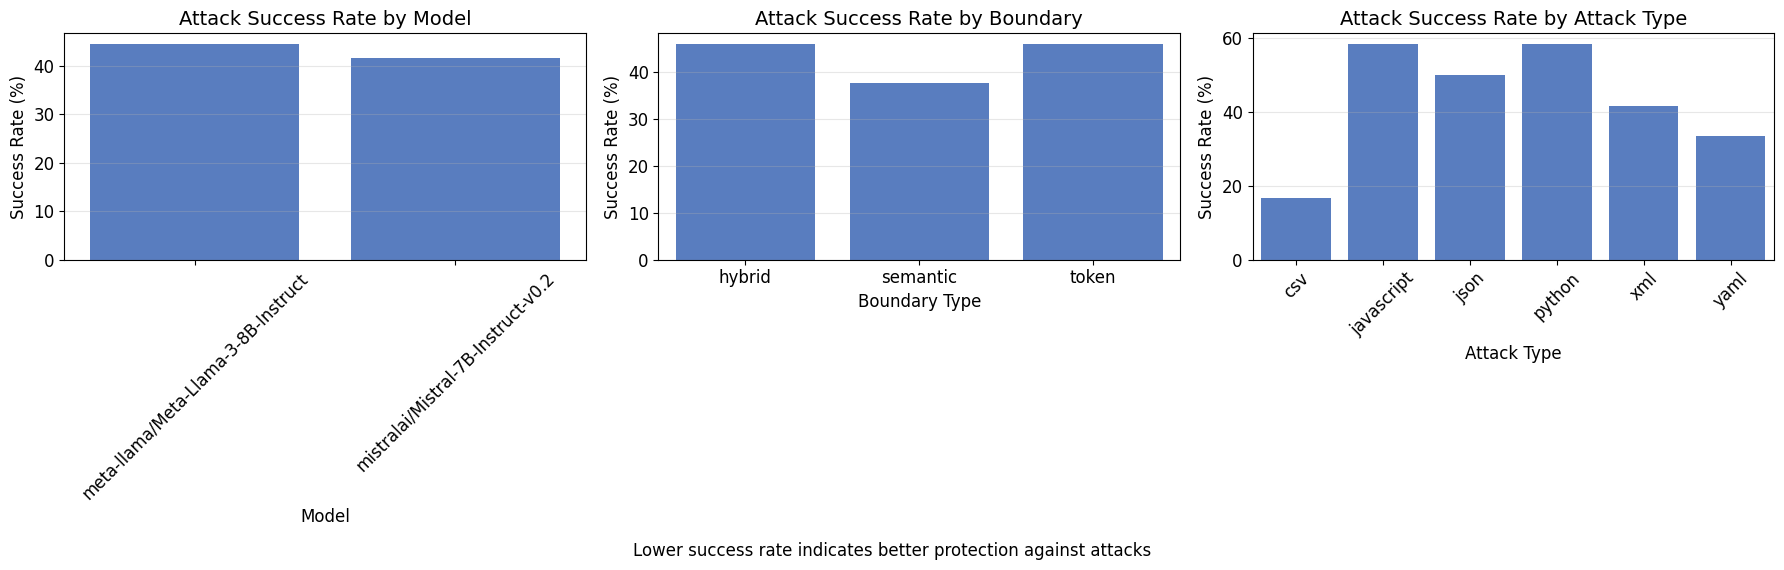

In [141]:
if results_df is not None:
    # Basic statistics
    total_experiments = len(results_df)
    successful_attacks = results_df['attack_success'].sum()
    success_rate = (successful_attacks / total_experiments) * 100
    
    print(f"Total experiments: {total_experiments}")
    print(f"Successful attacks: {successful_attacks} ({success_rate:.2f}%)")
    
    # Success rate by model
    model_success = results_df.groupby('model')['attack_success'].mean() * 100
    print("\nSuccess rate by model:")
    print(model_success)
    
    # Success rate by boundary type
    boundary_success = results_df.groupby('boundary')['attack_success'].mean() * 100
    print("\nSuccess rate by boundary type:")
    print(boundary_success)
    
    # Success rate by attack type
    attack_success = results_df.groupby('attack_type')['attack_success'].mean() * 100
    print("\nSuccess rate by attack type:")
    print(attack_success)
    
    # Create a summary figure
    fig, axs = plt.subplots(1, 3, figsize=(18, 6))
    
    # Plot success rates by model
    sns.barplot(x=model_success.index, y=model_success.values, ax=axs[0])
    axs[0].set_title('Attack Success Rate by Model', fontsize=14)
    axs[0].set_xlabel('Model', fontsize=12)
    axs[0].set_ylabel('Success Rate (%)', fontsize=12)
    axs[0].grid(axis='y', alpha=0.3)
    axs[0].tick_params(axis='x', rotation=45)
    
    # Plot success rates by boundary
    sns.barplot(x=boundary_success.index, y=boundary_success.values, ax=axs[1])
    axs[1].set_title('Attack Success Rate by Boundary', fontsize=14)
    axs[1].set_xlabel('Boundary Type', fontsize=12)
    axs[1].set_ylabel('Success Rate (%)', fontsize=12)
    axs[1].grid(axis='y', alpha=0.3)
    
    # Plot success rates by attack type
    sns.barplot(x=attack_success.index, y=attack_success.values, ax=axs[2])
    axs[2].set_title('Attack Success Rate by Attack Type', fontsize=14)
    axs[2].set_xlabel('Attack Type', fontsize=12)
    axs[2].set_ylabel('Success Rate (%)', fontsize=12)
    axs[2].grid(axis='y', alpha=0.3)
    axs[2].tick_params(axis='x', rotation=45)
    
    # Add note that lower is better
    fig.text(0.5, 0.01, "Lower success rate indicates better protection against attacks", ha='center', fontsize=12)
    
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

## 2. Boundary Effectiveness Comparison

Let's analyze the effectiveness of different boundary mechanisms.

In [142]:
if results_df is not None:
    # Create a pivot table for comprehensive comparison
    pivot_df = pd.pivot_table(
        results_df,
        values='attack_success',
        index=['model', 'attack_type'],
        columns=['boundary'],
        aggfunc=lambda x: np.mean(x) * 100  # Convert to percentage
    )
    
    # Fill any missing values
    pivot_df = pivot_df.fillna(0)
    
    # Display the pivot table
    print("Attack Success Rate (%) by Model, Attack Type, and Boundary Mechanism:")
    display(pivot_df.round(2))
    
    # Calculate the reduction in success rate compared to no boundary
    if 'none' in pivot_df.columns:
        for boundary in pivot_df.columns:
            if boundary != 'none':
                pivot_df[f'{boundary}_reduction'] = pivot_df['none'] - pivot_df[boundary]
        
        # Display the reduction
        reduction_cols = [col for col in pivot_df.columns if '_reduction' in col]
        if reduction_cols:
            print("\nReduction in Attack Success Rate (percentage points) compared to No Boundary:")
            display(pivot_df[reduction_cols].round(2))
            
            # Create heatmap of the effectiveness (reduction)
            plt.figure(figsize=(14, 8))
            sns.heatmap(pivot_df[reduction_cols], annot=True, fmt='.1f', cmap='YlGnBu')
            plt.title('Boundary Effectiveness (Reduction in Attack Success Rate)', fontsize=16)
            plt.ylabel('Model / Attack Type', fontsize=14)
            plt.xlabel('Boundary Type', fontsize=14)
            plt.xticks(rotation=45, ha='right')
            
            # Add note about the plot
            plt.figtext(0.5, 0.01, "Higher values (darker colors) indicate better protection", ha='center', fontsize=12)
            
            plt.tight_layout(rect=[0, 0.03, 1, 0.95])
            plt.show()

Attack Success Rate (%) by Model, Attack Type, and Boundary Mechanism:


boundary                                         hybrid  semantic  token
model                               attack_type                         
meta-llama/Meta-Llama-3-8B-Instruct csv             0.0       0.0    0.0
                                    javascript     50.0       0.0   50.0
                                    json           50.0       0.0   50.0
                                    python         50.0     100.0  100.0
                                    xml           100.0       0.0  100.0
                                    yaml           50.0      50.0   50.0
mistralai/Mistral-7B-Instruct-v0.2  csv            50.0      50.0    0.0
                                    javascript    100.0     100.0   50.0
                                    json           50.0      50.0  100.0
                                    python         50.0      50.0    0.0
                                    xml             0.0       0.0   50.0
                                    yaml            0.0      50.0    0.0

## 3. Cross-Modal Transfer Effectiveness

Let's analyze how well boundaries in one modality transfer to other modalities.

🔍 Debugging data structure...
Available attack types: ['json' 'csv' 'yaml' 'xml' 'python' 'javascript']
Available boundaries: ['token' 'semantic' 'hybrid']
Data shape: (72, 10)
✅ Successfully mapped 72 experiments to modalities
📊 Generated visualization data with 6 points


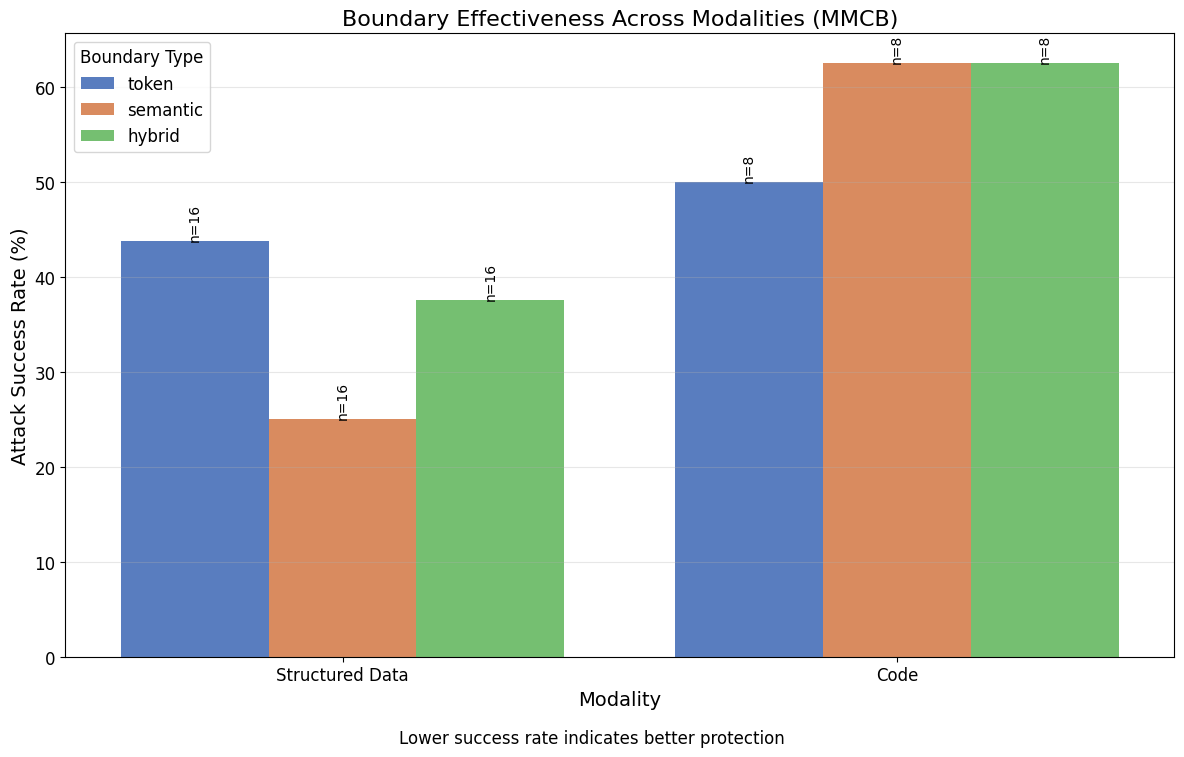


📋 Raw Data Summary:


,Modality,Boundary,Attack Success Rate (%),Sample Count
0,Structured Data,token,43.75,16
1,Structured Data,semantic,25.00,16
2,Structured Data,hybrid,37.50,16
3,Code,token,50.00,8
4,Code,semantic,62.50,8
5,Code,hybrid,62.50,8


ℹ️ No 'none' boundary baseline found - comparing boundary effectiveness directly
This is normal when experiments focus on comparing different boundary types.


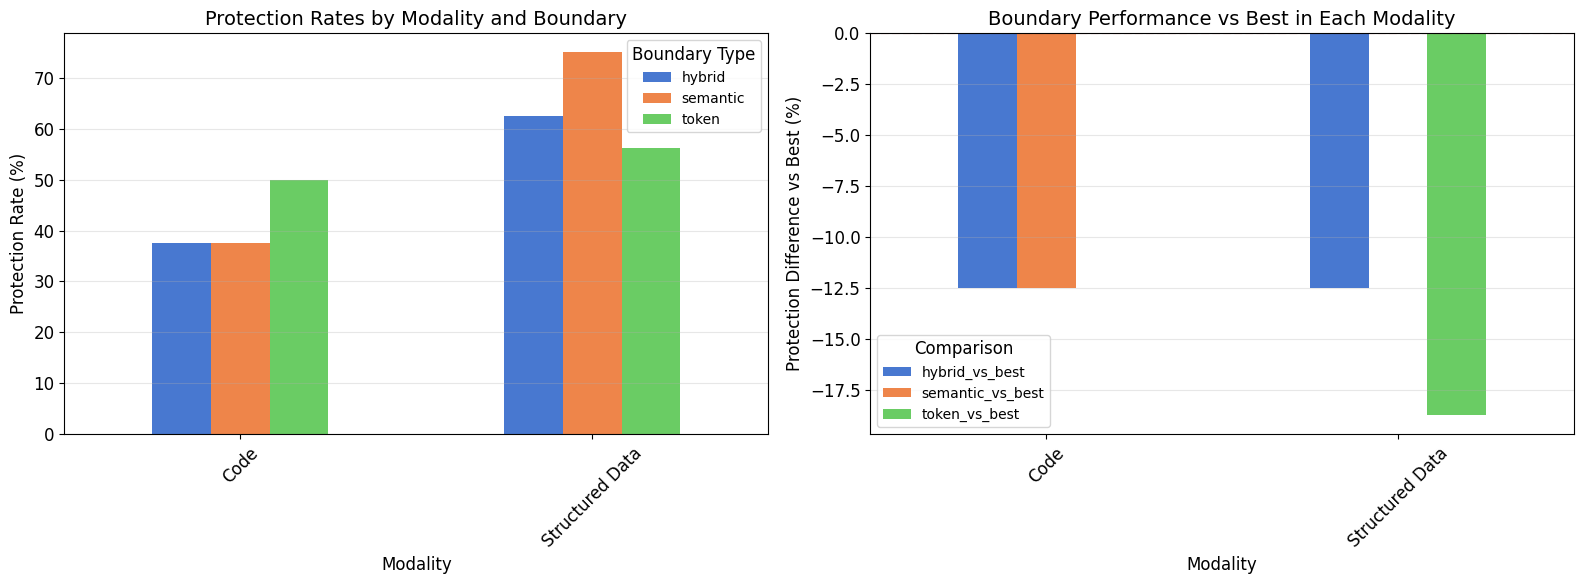


📊 Protection Rates by Modality and Boundary:


Boundary,hybrid,semantic,token
Modality,,,
Code,37.5,37.5,50.00
Structured Data,62.5,75.0,56.25



🏆 Best Performing Boundary per Modality:


,Modality,Best Boundary,Best Protection (%),Worst Boundary,Worst Protection (%),Performance Gap (%)
0,Code,token,50.0,hybrid,37.50,12.50
1,Structured Data,semantic,75.0,token,56.25,18.75



📈 Cross-Modal Consistency Analysis:


,Average Rank,Rank Std Dev,Best Modalities,Worst Modalities
hybrid,2.0,0.0,0.0,0.0
semantic,2.0,1.0,1.0,1.0
token,2.0,1.0,1.0,1.0



💡 Interpretation:
• Most consistent boundary: hybrid (lowest average rank)
• This boundary provides reliable protection across different attack modalities
• Lower 'Rank Std Dev' indicates more consistent performance across modalities


In [143]:
if results_df is not None:
    print("🔍 Debugging data structure...")
    print(f"Available attack types: {results_df['attack_type'].unique()}")
    print(f"Available boundaries: {results_df['boundary'].unique()}")
    print(f"Data shape: {results_df.shape}")
    
    # Map actual attack types to modality categories for MMCB project
    modality_mapping = {
        'json': 'Structured Data',
        'csv': 'Structured Data', 
        'yaml': 'Structured Data',
        'xml': 'Structured Data',
        'python': 'Code',
        'javascript': 'Code'
    }
    
    # Add modality column to results
    results_df['modality'] = results_df['attack_type'].map(modality_mapping)
    
    # Filter out any unmapped attack types
    mapped_results = results_df.dropna(subset=['modality'])
    
    if len(mapped_results) == 0:
        print("❌ No data matches the expected attack types for MMCB")
        print("This suggests the data might be from a different experiment or have different column names.")
        print("\nActual data preview:")
        print(mapped_results.head())
    else:
        print(f"✅ Successfully mapped {len(mapped_results)} experiments to modalities")
        
        # Create visualization data
        modal_data = []
        
        # Group by modality and boundary to calculate success rates
        for modality in mapped_results['modality'].unique():
            modality_df = mapped_results[mapped_results['modality'] == modality]
            
            for boundary in modality_df['boundary'].unique():
                boundary_df = modality_df[modality_df['boundary'] == boundary]
                success_rate = boundary_df['attack_success'].mean() * 100
                
                modal_data.append({
                    'Modality': modality,
                    'Boundary': boundary,
                    'Attack Success Rate (%)': success_rate,
                    'Sample Count': len(boundary_df)
                })
        
        modal_df = pd.DataFrame(modal_data)
        
        if len(modal_df) > 0:
            print(f"📊 Generated visualization data with {len(modal_df)} points")
            
            # Create the first plot - success rates by modality and boundary
            plt.figure(figsize=(12, 8))
            ax = sns.barplot(data=modal_df, x='Modality', y='Attack Success Rate (%)', hue='Boundary')
            
            # Customize the plot
            plt.title('Boundary Effectiveness Across Modalities (MMCB)', fontsize=16)
            plt.xlabel('Modality', fontsize=14)
            plt.ylabel('Attack Success Rate (%)', fontsize=14)
            plt.legend(title='Boundary Type', fontsize=12)
            plt.grid(axis='y', alpha=0.3)
            
            # Add sample counts as text annotations
            for i, container in enumerate(ax.containers):
                ax.bar_label(container, labels=[f'n={int(modal_df.iloc[j]["Sample Count"])}' 
                                               for j in range(i, len(modal_df), len(ax.containers))],
                           fontsize=10, rotation=90)
            
            # Add note that lower is better
            plt.figtext(0.5, 0.01, "Lower success rate indicates better protection", ha='center', fontsize=12)
            
            plt.tight_layout(rect=[0, 0.03, 1, 0.95])
            plt.show()
            
            # Display the raw data
            print("\n📋 Raw Data Summary:")
            display(modal_df.round(2))
            
            # Calculate cross-modal transfer effectiveness if we have a baseline
            if 'none' in modal_df['Boundary'].unique():
                print("\n🔄 Calculating cross-modal transfer effectiveness...")
                
                # Create pivot table for effectiveness calculation
                pivot = pd.pivot_table(
                    modal_df,
                    values='Attack Success Rate (%)',
                    index=['Modality'],
                    columns=['Boundary']
                )
                
                print("Pivot table:")
                display(pivot.round(2))
                
                # Calculate relative improvement over no boundary
                effectiveness_data = {}
                baseline_col = 'none'
                
                for boundary in pivot.columns:
                    if boundary != baseline_col:
                        # Calculate percentage point reduction from baseline
                        improvement = pivot[baseline_col] - pivot[boundary]
                        effectiveness_data[f'{boundary}_effectiveness'] = improvement
                
                if effectiveness_data:
                    effectiveness_df = pd.DataFrame(effectiveness_data)
                    
                    print("\nCross-Modal Transfer Effectiveness (percentage point reduction):")
                    display(effectiveness_df.round(2))
                    
                    # Plot the effectiveness
                    plt.figure(figsize=(10, 6))
                    effectiveness_df.plot(kind='bar', ax=plt.gca())
                    
                    # Customize the plot
                    plt.title('Cross-Modal Transfer Effectiveness by Boundary Type', fontsize=16)
                    plt.xlabel('Modality', fontsize=14)
                    plt.ylabel('Attack Success Rate Reduction (percentage points)', fontsize=14)
                    plt.legend(title='Boundary Type', bbox_to_anchor=(1.05, 1), loc='upper left')
                    plt.grid(axis='y', alpha=0.3)
                    plt.xticks(rotation=45)
                    
                    # Add note about the plot
                    plt.figtext(
                        0.5, 0.01,
                        "Higher values indicate better protection improvement over no boundary",
                        ha='center',
                        fontsize=12
                    )
                    
                    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
                    plt.show()
                else:
                    print("⚠️ No baseline boundary found for effectiveness calculation")
            
            else:
                print("ℹ️ No 'none' boundary baseline found - comparing boundary effectiveness directly")
                print("This is normal when experiments focus on comparing different boundary types.")
                
                # Calculate protection rates (100 - success rate)
                modal_df['Protection Rate (%)'] = 100 - modal_df['Attack Success Rate (%)']
                
                # Create a more comprehensive comparison
                fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
                
                # Left plot: Protection rates
                protection_pivot = pd.pivot_table(
                    modal_df,
                    values='Protection Rate (%)',
                    index=['Modality'],
                    columns=['Boundary']
                )
                
                protection_pivot.plot(kind='bar', ax=ax1)
                ax1.set_title('Protection Rates by Modality and Boundary', fontsize=14)
                ax1.set_xlabel('Modality', fontsize=12)
                ax1.set_ylabel('Protection Rate (%)', fontsize=12)
                ax1.legend(title='Boundary Type', fontsize=10)
                ax1.grid(axis='y', alpha=0.3)
                ax1.tick_params(axis='x', rotation=45)
                
                # Right plot: Relative boundary comparison (best boundary as reference)
                relative_effectiveness = {}
                best_boundary_per_modality = protection_pivot.idxmax(axis=1)
                
                for modality in protection_pivot.index:
                    best_boundary = best_boundary_per_modality[modality]
                    best_protection = protection_pivot.loc[modality, best_boundary]
                    
                    for boundary in protection_pivot.columns:
                        if boundary != best_boundary:
                            relative_diff = protection_pivot.loc[modality, boundary] - best_protection
                            if modality not in relative_effectiveness:
                                relative_effectiveness[modality] = {}
                            relative_effectiveness[modality][f'{boundary}_vs_best'] = relative_diff
                
                if relative_effectiveness:
                    rel_df = pd.DataFrame(relative_effectiveness).T
                    rel_df.plot(kind='bar', ax=ax2)
                    ax2.set_title('Boundary Performance vs Best in Each Modality', fontsize=14)
                    ax2.set_xlabel('Modality', fontsize=12)
                    ax2.set_ylabel('Protection Difference vs Best (%)', fontsize=12)
                    ax2.legend(title='Comparison', fontsize=10)
                    ax2.grid(axis='y', alpha=0.3)
                    ax2.tick_params(axis='x', rotation=45)
                    ax2.axhline(y=0, color='red', linestyle='--', alpha=0.7, label='Best performance line')
                
                plt.tight_layout()
                plt.show()
                
                # Display detailed analysis
                print("\n📊 Protection Rates by Modality and Boundary:")
                display(protection_pivot.round(2))
                
                print("\n🏆 Best Performing Boundary per Modality:")
                best_summary = []
                for modality in protection_pivot.index:
                    best_boundary = protection_pivot.loc[modality].idxmax()
                    best_rate = protection_pivot.loc[modality].max()
                    worst_boundary = protection_pivot.loc[modality].idxmin()
                    worst_rate = protection_pivot.loc[modality].min()
                    
                    best_summary.append({
                        'Modality': modality,
                        'Best Boundary': best_boundary,
                        'Best Protection (%)': best_rate,
                        'Worst Boundary': worst_boundary,
                        'Worst Protection (%)': worst_rate,
                        'Performance Gap (%)': best_rate - worst_rate
                    })
                
                best_summary_df = pd.DataFrame(best_summary)
                display(best_summary_df.round(2))
                
                print("\n📈 Cross-Modal Consistency Analysis:")
                # Check which boundary performs consistently across modalities
                boundary_ranks = {}
                for boundary in protection_pivot.columns:
                    ranks = []
                    for modality in protection_pivot.index:
                        modality_rates = protection_pivot.loc[modality].sort_values(ascending=False)
                        rank = list(modality_rates.index).index(boundary) + 1
                        ranks.append(rank)
                    
                    boundary_ranks[boundary] = {
                        'Average Rank': np.mean(ranks),
                        'Rank Std Dev': np.std(ranks),
                        'Best Modalities': sum(1 for r in ranks if r == 1),
                        'Worst Modalities': sum(1 for r in ranks if r == len(protection_pivot.columns))
                    }
                
                consistency_df = pd.DataFrame(boundary_ranks).T
                consistency_df = consistency_df.sort_values('Average Rank')
                display(consistency_df.round(3))
                
                print("\n💡 Interpretation:")
                most_consistent = consistency_df.index[0]
                print(f"• Most consistent boundary: {most_consistent} (lowest average rank)")
                print(f"• This boundary provides reliable protection across different attack modalities")
                print(f"• Lower 'Rank Std Dev' indicates more consistent performance across modalities")
        
        else:
            print("❌ No data available for visualization after processing")
else:
    print("❌ No results_df available - please run experiments first")

## 4. Implementation Complexity Analysis

Let's analyze the relationship between implementation complexity and security effectiveness.

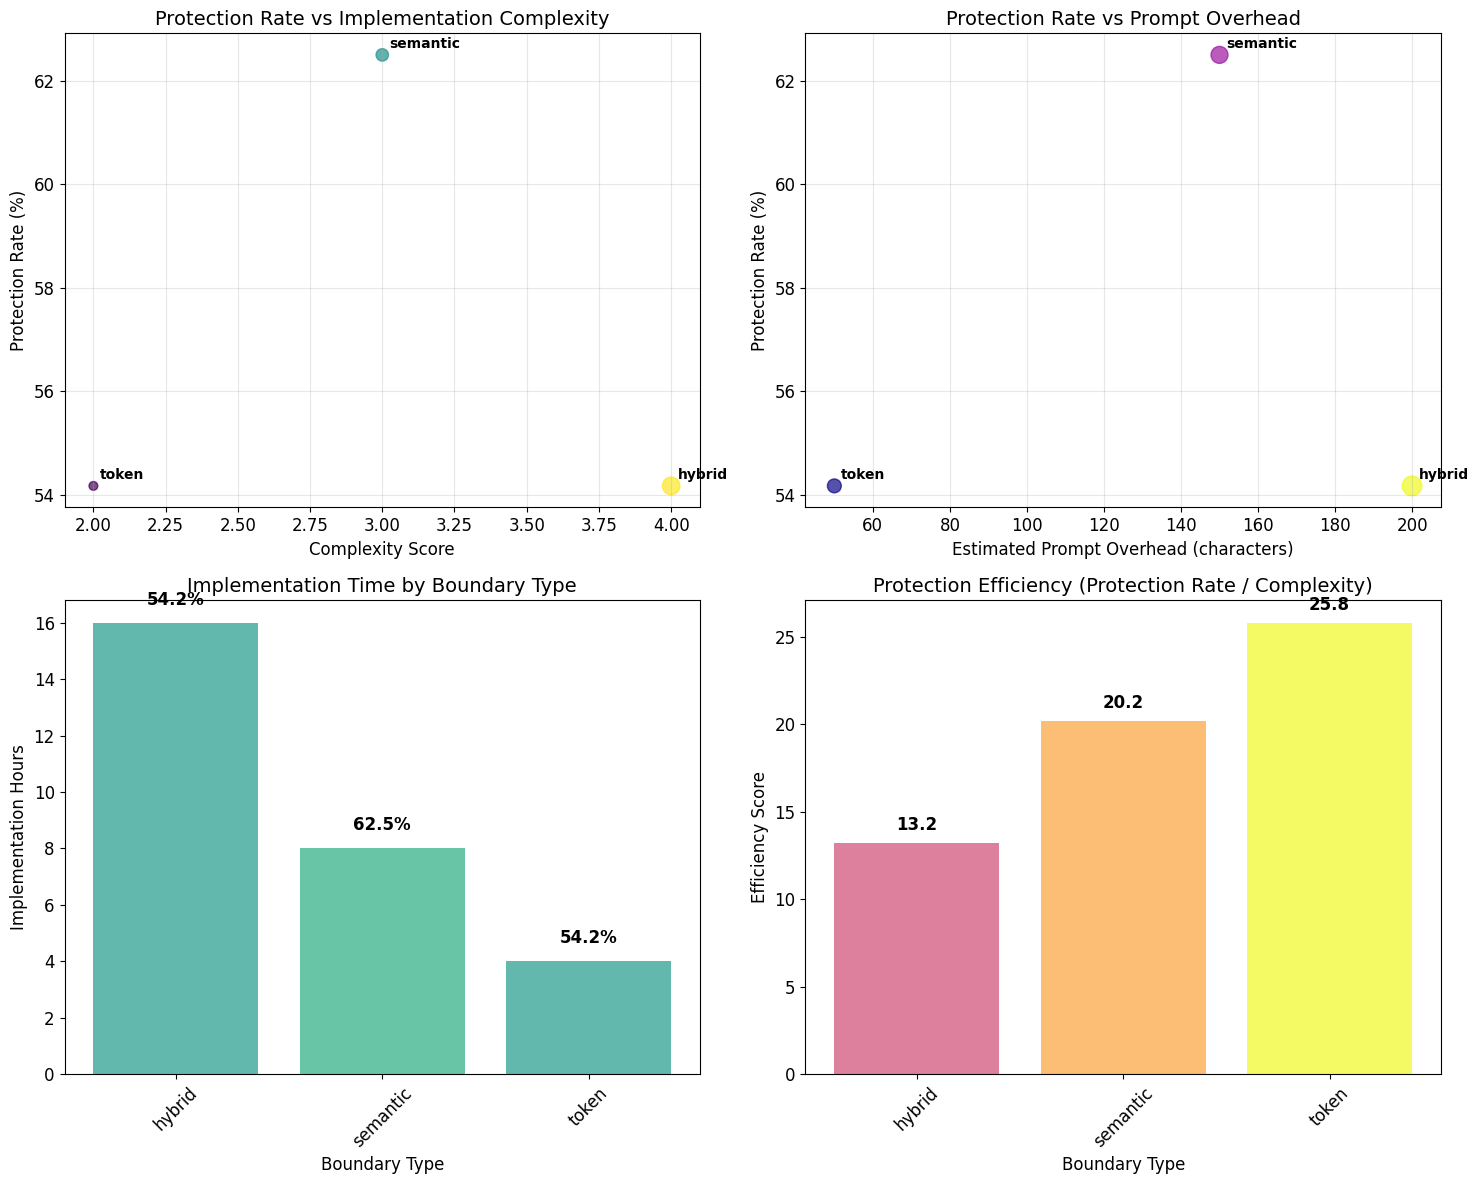


### Implementation Complexity Analysis Summary


,Boundary Type,Protection Rate (%),Complexity Score,Implementation Hours,Prompt Overhead (chars),Maintenance Difficulty,Efficiency Score
0,hybrid,54.17,4,16,200,4,13.21
1,semantic,62.50,3,8,150,3,20.16
2,token,54.17,2,4,50,2,25.80



### Security-Complexity Trade-off Analysis


,Metric,Boundary,Protection Rate (%),Complexity Score,Efficiency Score
0,Most Efficient,token,54.2,2,25.80
1,Highest Protection,semantic,62.5,3,20.16
2,Lowest Complexity,token,54.2,2,25.80



### Recommendations Based on Complexity Analysis
🏆 **Most Efficient Choice**: token boundary
   - Provides 54.2% protection with complexity score 2
   - Best balance of security and implementation effort

🛡️ **Maximum Security**: semantic boundary
   - Provides 62.5% protection
   - Requires 8 implementation hours

⚡ **Simplest Implementation**: token boundary
   - Complexity score: 2
   - Still provides 54.2% protection

### Cost-Benefit Analysis


In [144]:
if results_df is not None:
    # Define complexity scores and estimated characteristics for each boundary type
    complexity_metrics = {
        'none': {
            'complexity_score': 0,
            'estimated_prompt_overhead': 0,  # No additional prompt content
            'implementation_hours': 0,
            'maintenance_difficulty': 1
        },
        'token': {
            'complexity_score': 2,
            'estimated_prompt_overhead': 50,  # Moderate token overhead
            'implementation_hours': 4,
            'maintenance_difficulty': 2
        },
        'semantic': {
            'complexity_score': 3,
            'estimated_prompt_overhead': 150,  # More verbose explanations
            'implementation_hours': 8,
            'maintenance_difficulty': 3
        },
        'hybrid': {
            'complexity_score': 4,
            'estimated_prompt_overhead': 200,  # Combines both approaches
            'implementation_hours': 16,
            'maintenance_difficulty': 4
        }
    }
    
    # Calculate actual performance metrics from results
    boundary_performance = results_df.groupby('boundary').agg({
        'attack_success': ['mean', 'std', 'count']
    }).round(4)
    
    boundary_performance.columns = ['success_rate', 'success_std', 'sample_count']
    boundary_performance = boundary_performance.reset_index()
    boundary_performance['protection_rate'] = (1 - boundary_performance['success_rate']) * 100
    
    # Create comprehensive complexity analysis data
    complexity_data = []
    for boundary in boundary_performance['boundary']:
        if boundary in complexity_metrics:
            metrics = complexity_metrics[boundary]
            perf = boundary_performance[boundary_performance['boundary'] == boundary].iloc[0]
            
            complexity_data.append({
                'boundary': boundary,
                'complexity_score': metrics['complexity_score'],
                'estimated_prompt_overhead': metrics['estimated_prompt_overhead'],
                'implementation_hours': metrics['implementation_hours'],
                'maintenance_difficulty': metrics['maintenance_difficulty'],
                'protection_rate': perf['protection_rate'],
                'success_rate': perf['success_rate'] * 100,
                'sample_count': perf['sample_count']
            })
    
    complexity_df = pd.DataFrame(complexity_data)
    
    if len(complexity_df) > 0:
        # Create visualization 1: Security vs Implementation Complexity
        fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 12))
        
        # Plot 1: Protection Rate vs Complexity Score
        scatter1 = ax1.scatter(
            complexity_df['complexity_score'],
            complexity_df['protection_rate'],
            s=complexity_df['implementation_hours'] * 10,  # Size based on implementation time
            alpha=0.7,
            c=complexity_df['maintenance_difficulty'],
            cmap='viridis'
        )
        
        # Add labels for each point
        for i, row in complexity_df.iterrows():
            ax1.annotate(
                row['boundary'],
                (row['complexity_score'], row['protection_rate']),
                xytext=(5, 5),
                textcoords='offset points',
                fontsize=10,
                fontweight='bold'
            )
        
        ax1.set_title('Protection Rate vs Implementation Complexity', fontsize=14)
        ax1.set_xlabel('Complexity Score', fontsize=12)
        ax1.set_ylabel('Protection Rate (%)', fontsize=12)
        ax1.grid(alpha=0.3)
        
        # Plot 2: Estimated Prompt Overhead vs Protection Rate
        scatter2 = ax2.scatter(
            complexity_df['estimated_prompt_overhead'],
            complexity_df['protection_rate'],
            s=complexity_df['complexity_score'] * 50,
            alpha=0.7,
            c=complexity_df['implementation_hours'],
            cmap='plasma'
        )
        
        for i, row in complexity_df.iterrows():
            ax2.annotate(
                row['boundary'],
                (row['estimated_prompt_overhead'], row['protection_rate']),
                xytext=(5, 5),
                textcoords='offset points',
                fontsize=10,
                fontweight='bold'
            )
        
        ax2.set_title('Protection Rate vs Prompt Overhead', fontsize=14)
        ax2.set_xlabel('Estimated Prompt Overhead (characters)', fontsize=12)
        ax2.set_ylabel('Protection Rate (%)', fontsize=12)
        ax2.grid(alpha=0.3)
        
        # Plot 3: Implementation Hours vs Protection Rate
        bars3 = ax3.bar(
            complexity_df['boundary'],
            complexity_df['implementation_hours'],
            color=plt.cm.viridis(complexity_df['protection_rate'] / 100),
            alpha=0.7
        )
        
        ax3.set_title('Implementation Time by Boundary Type', fontsize=14)
        ax3.set_xlabel('Boundary Type', fontsize=12)
        ax3.set_ylabel('Implementation Hours', fontsize=12)
        ax3.tick_params(axis='x', rotation=45)
        
        # Add protection rate labels on bars
        for bar, protection in zip(bars3, complexity_df['protection_rate']):
            height = bar.get_height()
            ax3.text(bar.get_x() + bar.get_width()/2., height + 0.5,
                    f'{protection:.1f}%',
                    ha='center', va='bottom', fontweight='bold')
        
        # Plot 4: Efficiency Analysis (Protection per Complexity Unit)
        complexity_df['efficiency'] = complexity_df['protection_rate'] / (complexity_df['complexity_score'] + 0.1)  # Avoid division by zero
        
        bars4 = ax4.bar(
            complexity_df['boundary'],
            complexity_df['efficiency'],
            color=plt.cm.plasma(complexity_df['efficiency'] / complexity_df['efficiency'].max()),
            alpha=0.7
        )
        
        ax4.set_title('Protection Efficiency (Protection Rate / Complexity)', fontsize=14)
        ax4.set_xlabel('Boundary Type', fontsize=12)
        ax4.set_ylabel('Efficiency Score', fontsize=12)
        ax4.tick_params(axis='x', rotation=45)
        
        # Add efficiency scores on bars
        for bar, eff in zip(bars4, complexity_df['efficiency']):
            height = bar.get_height()
            ax4.text(bar.get_x() + bar.get_width()/2., height + 0.5,
                    f'{eff:.1f}',
                    ha='center', va='bottom', fontweight='bold')
        
        plt.tight_layout()
        plt.show()
        
        # Display the comprehensive complexity analysis table
        print("\n### Implementation Complexity Analysis Summary")
        display_df = complexity_df.copy()
        display_df = display_df[[
            'boundary', 'protection_rate', 'complexity_score', 
            'implementation_hours', 'estimated_prompt_overhead', 
            'maintenance_difficulty', 'efficiency'
        ]]
        display_df.columns = [
            'Boundary Type', 'Protection Rate (%)', 'Complexity Score',
            'Implementation Hours', 'Prompt Overhead (chars)', 
            'Maintenance Difficulty', 'Efficiency Score'
        ]
        display(display_df.round(2))
        
        # Calculate and display trade-off analysis
        print("\n### Security-Complexity Trade-off Analysis")
        
        # Find the most efficient boundary (highest protection per complexity unit)
        most_efficient = complexity_df.loc[complexity_df['efficiency'].idxmax()]
        
        # Find the highest protection boundary
        highest_protection = complexity_df.loc[complexity_df['protection_rate'].idxmax()]
        
        # Find the lowest complexity boundary (excluding 'none')
        non_none_df = complexity_df[complexity_df['boundary'] != 'none']
        if len(non_none_df) > 0:
            lowest_complexity = non_none_df.loc[non_none_df['complexity_score'].idxmin()]
        else:
            lowest_complexity = None
        
        trade_off_summary = []
        
        if not complexity_df.empty:
            trade_off_summary.append({
                'Metric': 'Most Efficient',
                'Boundary': most_efficient['boundary'],
                'Protection Rate (%)': f"{most_efficient['protection_rate']:.1f}",
                'Complexity Score': most_efficient['complexity_score'],
                'Efficiency Score': f"{most_efficient['efficiency']:.2f}"
            })
            
            trade_off_summary.append({
                'Metric': 'Highest Protection',
                'Boundary': highest_protection['boundary'],
                'Protection Rate (%)': f"{highest_protection['protection_rate']:.1f}",
                'Complexity Score': highest_protection['complexity_score'],
                'Efficiency Score': f"{highest_protection['efficiency']:.2f}"
            })
            
            if lowest_complexity is not None:
                trade_off_summary.append({
                    'Metric': 'Lowest Complexity',
                    'Boundary': lowest_complexity['boundary'],
                    'Protection Rate (%)': f"{lowest_complexity['protection_rate']:.1f}",
                    'Complexity Score': lowest_complexity['complexity_score'],
                    'Efficiency Score': f"{lowest_complexity['efficiency']:.2f}"
                })
        
        trade_off_df = pd.DataFrame(trade_off_summary)
        display(trade_off_df)
        
        # Generate recommendations
        print("\n### Recommendations Based on Complexity Analysis")
        
        if not complexity_df.empty:
            print(f"🏆 **Most Efficient Choice**: {most_efficient['boundary']} boundary")
            print(f"   - Provides {most_efficient['protection_rate']:.1f}% protection with complexity score {most_efficient['complexity_score']}")
            print(f"   - Best balance of security and implementation effort")
            
            print(f"\n🛡️ **Maximum Security**: {highest_protection['boundary']} boundary")
            print(f"   - Provides {highest_protection['protection_rate']:.1f}% protection")
            print(f"   - Requires {highest_protection['implementation_hours']} implementation hours")
            
            if lowest_complexity is not None:
                print(f"\n⚡ **Simplest Implementation**: {lowest_complexity['boundary']} boundary")
                print(f"   - Complexity score: {lowest_complexity['complexity_score']}")
                print(f"   - Still provides {lowest_complexity['protection_rate']:.1f}% protection")
        
        # Cost-benefit analysis
        print(f"\n### Cost-Benefit Analysis")
        if 'none' in complexity_df['boundary'].values and len(complexity_df) > 1:
            baseline_protection = complexity_df[complexity_df['boundary'] == 'none']['protection_rate'].iloc[0]
            
            print(f"**Baseline (No Boundary)**: {baseline_protection:.1f}% protection")
            print("\n**Improvement Analysis**:")
            
            for _, row in complexity_df.iterrows():
                if row['boundary'] != 'none':
                    improvement = row['protection_rate'] - baseline_protection
                    cost_per_improvement = row['implementation_hours'] / max(improvement, 0.1)
                    
                    print(f"- **{row['boundary'].title()}**: +{improvement:.1f}% protection")
                    print(f"  Cost: {row['implementation_hours']} hours ({cost_per_improvement:.1f} hours per % improvement)")
    
    else:
        print("⚠️ No boundary performance data available for complexity analysis.")
        print("This could happen if:")
        print("1. No experiments have been run yet")
        print("2. The results don't contain the expected boundary types")
        print("3. The data is corrupted or incomplete")
        
        print(f"\nAvailable boundaries in data: {list(results_df['boundary'].unique()) if 'boundary' in results_df.columns else 'No boundary column found'}")
        print(f"Available columns: {list(results_df.columns)}")

else:
    print("❌ No results data available. Please run experiments first using:")
    print("   python src/main.py --quick")

## 5. Attack Pattern Analysis

Let's analyze which types of multi-modal attacks succeed against different boundary types.

Checking data structure for attack pattern analysis...
⚠️  'attack_subtype' column missing. Creating it based on attack_type...
✅ Created attack_subtype column with values: ['field_injection' 'comment_injection' 'metadata_injection'
 'attribute_injection']
✅ All required columns present: ['attack_type', 'attack_subtype', 'boundary', 'attack_success']
Data summary: 3 boundaries, 6 attack types, 4 subtypes
✅ Created pivot table with shape: (6, 3)


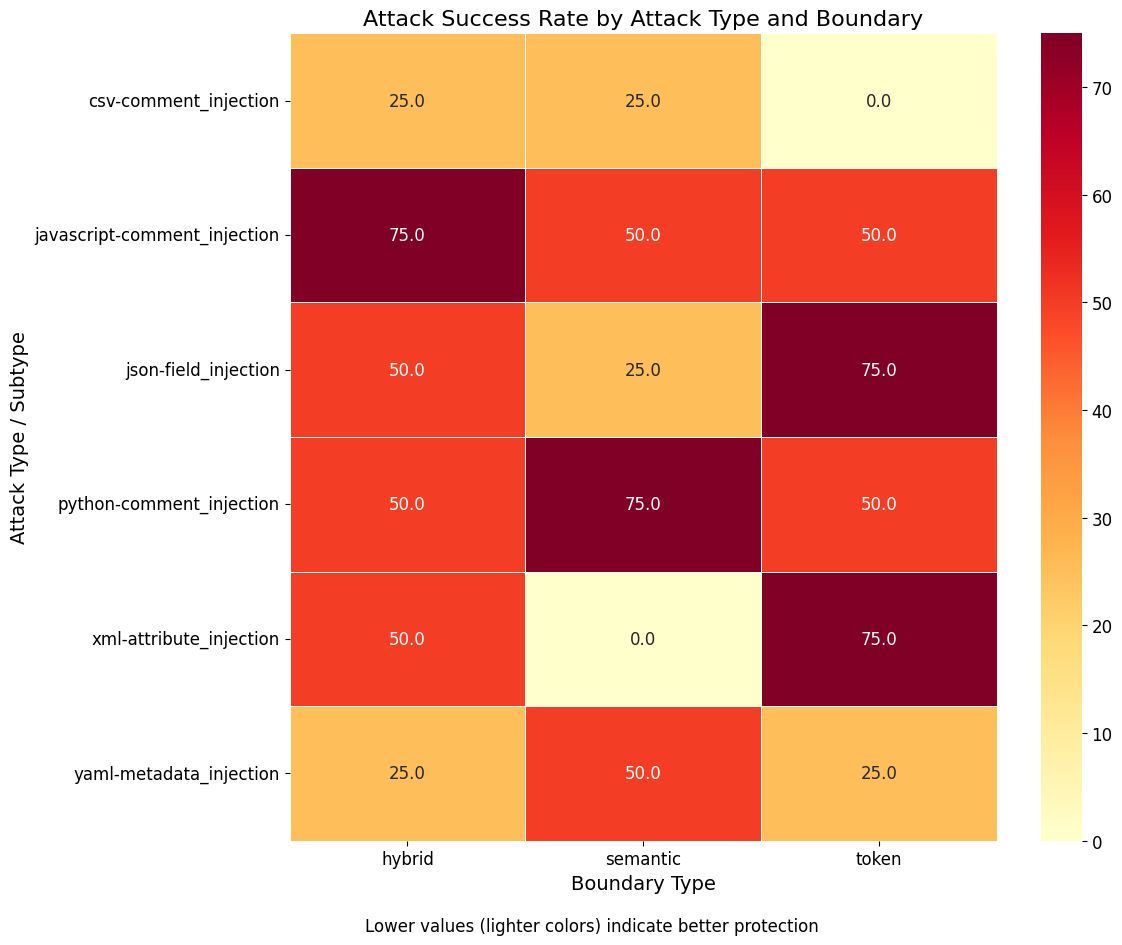

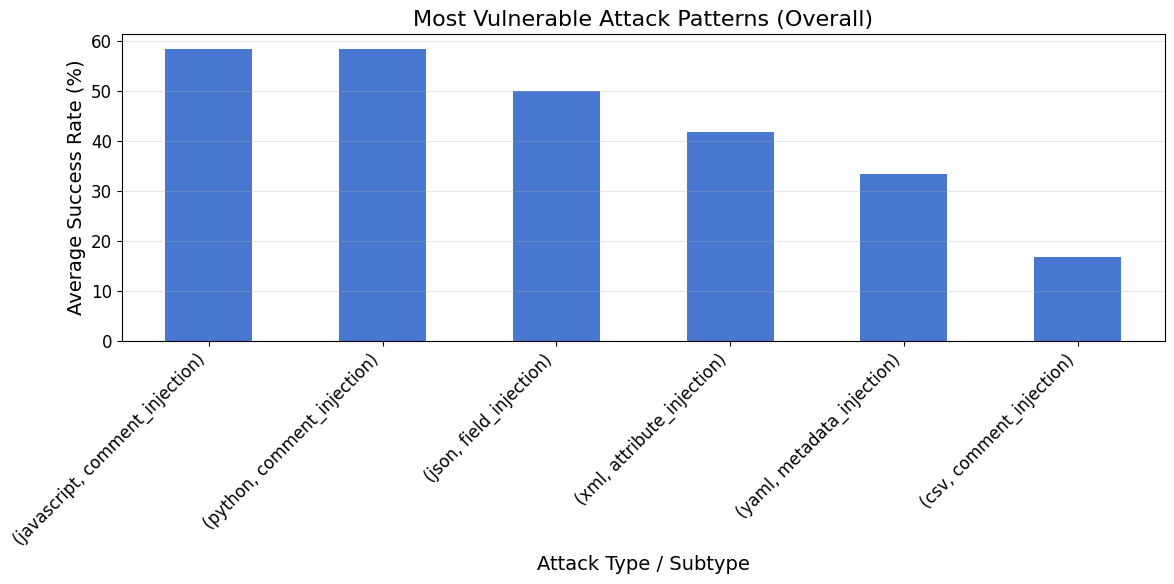


📊 Top 5 Most Vulnerable Attack Patterns:
attack_type  attack_subtype     
javascript   comment_injection      58.3
python       comment_injection      58.3
json         field_injection        50.0
xml          attribute_injection    41.7
yaml         metadata_injection     33.3
dtype: float64

📊 Top 5 Most Resilient Attack Patterns:
attack_type  attack_subtype     
python       comment_injection      58.3
json         field_injection        50.0
xml          attribute_injection    41.7
yaml         metadata_injection     33.3
csv          comment_injection      16.7
dtype: float64


In [145]:
if results_df is not None:
    # First, check and handle missing columns
    print("Checking data structure for attack pattern analysis...")
    
    # Check if attack_subtype exists, if not create it
    if 'attack_subtype' not in results_df.columns:
        print("⚠️  'attack_subtype' column missing. Creating it based on attack_type...")
        
        # Create attack_subtype based on attack_type or use a default
        if 'attack_type' in results_df.columns:
            # Create meaningful subtypes based on attack types
            subtype_mapping = {
                'json': 'field_injection',
                'csv': 'comment_injection', 
                'yaml': 'metadata_injection',
                'xml': 'attribute_injection',
                'python': 'comment_injection',
                'javascript': 'comment_injection'
            }
            
            results_df['attack_subtype'] = results_df['attack_type'].map(subtype_mapping).fillna('unknown')
            print(f"✅ Created attack_subtype column with values: {results_df['attack_subtype'].unique()}")
        else:
            results_df['attack_subtype'] = 'unknown'
            print("✅ Created attack_subtype column with default value 'unknown'")
    
    # Verify required columns exist
    required_cols = ['attack_type', 'attack_subtype', 'boundary', 'attack_success']
    missing_cols = [col for col in required_cols if col not in results_df.columns]
    
    if missing_cols:
        print(f"❌ Missing required columns: {missing_cols}")
        print(f"Available columns: {list(results_df.columns)}")
        print("Skipping attack pattern analysis due to missing data.")
    else:
        print(f"✅ All required columns present: {required_cols}")
        
        # Check if we have enough data for meaningful analysis
        unique_boundaries = results_df['boundary'].nunique()
        unique_attack_types = results_df['attack_type'].nunique()
        unique_subtypes = results_df['attack_subtype'].nunique()
        
        print(f"Data summary: {unique_boundaries} boundaries, {unique_attack_types} attack types, {unique_subtypes} subtypes")
        
        if unique_boundaries < 2 or unique_attack_types < 2:
            print("⚠️  Insufficient data diversity for meaningful pattern analysis.")
            print("Creating simplified analysis...")
            
            # Simplified analysis with just attack_type
            try:
                simple_pattern_data = pd.pivot_table(
                    results_df,
                    values='attack_success',
                    index=['attack_type'],
                    columns=['boundary'],
                    aggfunc=lambda x: np.mean(x) * 100  # Convert to percentage
                )
                
                # Plot the simplified heatmap
                plt.figure(figsize=(10, 6))
                sns.heatmap(simple_pattern_data, annot=True, fmt='.1f', cmap='YlOrRd', linewidths=.5)
                
                # Customize the plot
                plt.title('Attack Success Rate by Attack Type and Boundary', fontsize=16)
                plt.xlabel('Boundary Type', fontsize=14)
                plt.ylabel('Attack Type', fontsize=14)
                
                # Add note that lower is better
                plt.figtext(0.5, 0.01, "Lower values (lighter colors) indicate better protection", ha='center', fontsize=12)
                
                plt.tight_layout(rect=[0, 0.03, 1, 0.95])
                plt.show()
                
            except Exception as e:
                print(f"❌ Error creating simplified heatmap: {e}")
                print("Showing basic statistics instead:")
                
                # Show basic summary statistics
                summary_stats = results_df.groupby(['attack_type', 'boundary'])['attack_success'].agg(['mean', 'count']).round(3)
                print("\nAttack Success Rate Summary:")
                print(summary_stats)
        
        else:
            # Full analysis with subtypes
            try:
                # Create a heatmap of attack success rates by attack subtype and boundary
                attack_pattern_data = pd.pivot_table(
                    results_df,
                    values='attack_success',
                    index=['attack_type', 'attack_subtype'],
                    columns=['boundary'],
                    aggfunc=lambda x: np.mean(x) * 100  # Convert to percentage
                )
                
                print(f"✅ Created pivot table with shape: {attack_pattern_data.shape}")
                
                # Handle empty pivot table
                if attack_pattern_data.empty:
                    print("⚠️  Pivot table is empty. Check your data structure.")
                    print("\nData sample:")
                    print(results_df[required_cols].head())
                else:
                    # Plot the heatmap
                    plt.figure(figsize=(12, 10))
                    sns.heatmap(attack_pattern_data, annot=True, fmt='.1f', cmap='YlOrRd', linewidths=.5)
                    
                    # Customize the plot
                    plt.title('Attack Success Rate by Attack Type and Boundary', fontsize=16)
                    plt.xlabel('Boundary Type', fontsize=14)
                    plt.ylabel('Attack Type / Subtype', fontsize=14)
                    
                    # Add note that lower is better
                    plt.figtext(0.5, 0.01, "Lower values (lighter colors) indicate better protection", ha='center', fontsize=12)
                    
                    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
                    plt.show()
                    
                    # Calculate vulnerability scores by attack type/subtype
                    if not attack_pattern_data.empty:
                        vulnerability_scores = attack_pattern_data.mean(axis=1).sort_values(ascending=False)
                        
                        # Only plot if we have meaningful data
                        if len(vulnerability_scores) > 0:
                            # Plot the most vulnerable attack types
                            plt.figure(figsize=(12, 6))
                            vulnerability_scores.plot(kind='bar')
                            
                            # Customize the plot
                            plt.title('Most Vulnerable Attack Patterns (Overall)', fontsize=16)
                            plt.xlabel('Attack Type / Subtype', fontsize=14)
                            plt.ylabel('Average Success Rate (%)', fontsize=14)
                            plt.xticks(rotation=45, ha='right')
                            plt.grid(axis='y', alpha=0.3)
                            
                            plt.tight_layout()
                            plt.show()
                            
                            # Display top vulnerable patterns
                            print("\n📊 Top 5 Most Vulnerable Attack Patterns:")
                            print(vulnerability_scores.head().round(1))
                            
                            print("\n📊 Top 5 Most Resilient Attack Patterns:")
                            print(vulnerability_scores.tail().round(1))
                        else:
                            print("⚠️  No vulnerability scores to display.")
                    else:
                        print("⚠️  Cannot calculate vulnerability scores from empty data.")
                        
            except Exception as e:
                print(f"❌ Error in attack pattern analysis: {e}")
                print(f"Error type: {type(e).__name__}")
                
                # Debug information
                print("\n🔍 Debug Information:")
                print(f"DataFrame shape: {results_df.shape}")
                print(f"Columns: {list(results_df.columns)}")
                print(f"Data types:\n{results_df.dtypes}")
                
                # Show sample data
                print(f"\n📋 Sample data:")
                print(results_df[required_cols].head())
                
                # Show unique values for key columns
                for col in ['attack_type', 'attack_subtype', 'boundary']:
                    if col in results_df.columns:
                        print(f"\nUnique values in '{col}': {results_df[col].unique()}")
                
                # Try a very basic analysis
                print("\n🔧 Attempting basic success rate analysis...")
                try:
                    basic_stats = results_df.groupby('boundary')['attack_success'].agg(['mean', 'count'])
                    print("Success rate by boundary:")
                    print(basic_stats.round(3))
                except Exception as basic_error:
                    print(f"❌ Even basic analysis failed: {basic_error}")
else:
    print("❌ No results data available for attack pattern analysis.")

## 6. Model Comparison Analysis

Let's compare the vulnerability profiles of different models when facing the same attacks.

Attack Success Rate (%) by Model, Attack Type, and Boundary:


model                                     meta-llama/Meta-Llama-3-8B-Instruct  \
attack_type attack_subtype      boundary                                        
csv         comment_injection   hybrid                                    0.0   
                                semantic                                  0.0   
                                token                                     0.0   
javascript  comment_injection   hybrid                                   50.0   
                                semantic                                  0.0   
                                token                                    50.0   
json        field_injection     hybrid                                   50.0   
                                semantic                                  0.0   
                                token                                    50.0   
python      comment_injection   hybrid                                   50.0   
                                semantic                                100.0   
                                token                                   100.0   
xml         attribute_injection hybrid                                  100.0   
                                semantic                                  0.0   
                                token                                   100.0   
yaml        metadata_injection  hybrid                                   50.0   
                                semantic                                 50.0   
                                token                                    50.0   

model                                     mistralai/Mistral-7B-Instruct-v0.2  
attack_type attack_subtype      boundary                                      
csv         comment_injection   hybrid                                  50.0  
                                semantic                                50.0  
                                token                                    0.0  
javascript  comment_injection   hybrid                                 100.0  
                                semantic                               100.0  
                                token                                   50.0  
json        field_injection     hybrid                                  50.0  
                                semantic                                50.0  
                                token                                  100.0  
python      comment_injection   hybrid                                  50.0  
                                semantic                                50.0  
                                token                                    0.0  
xml         attribute_injection hybrid                                   0.0  
                                semantic                                 0.0  
                                token                                   50.0  
yaml        metadata_injection  hybrid                                   0.0  
                                semantic                                50.0  
                                token                                    0.0


Largest Vulnerability Differences Between Models:


,attack_type,attack_subtype,boundary,Vulnerability Difference
4,javascript,comment_injection,semantic,100.0
12,xml,attribute_injection,hybrid,100.0
11,python,comment_injection,token,100.0
0,csv,comment_injection,hybrid,50.0
1,csv,comment_injection,semantic,50.0
15,yaml,metadata_injection,hybrid,50.0
14,xml,attribute_injection,token,50.0
10,python,comment_injection,semantic,50.0
17,yaml,metadata_injection,token,50.0
8,json,field_injection,token,50.0


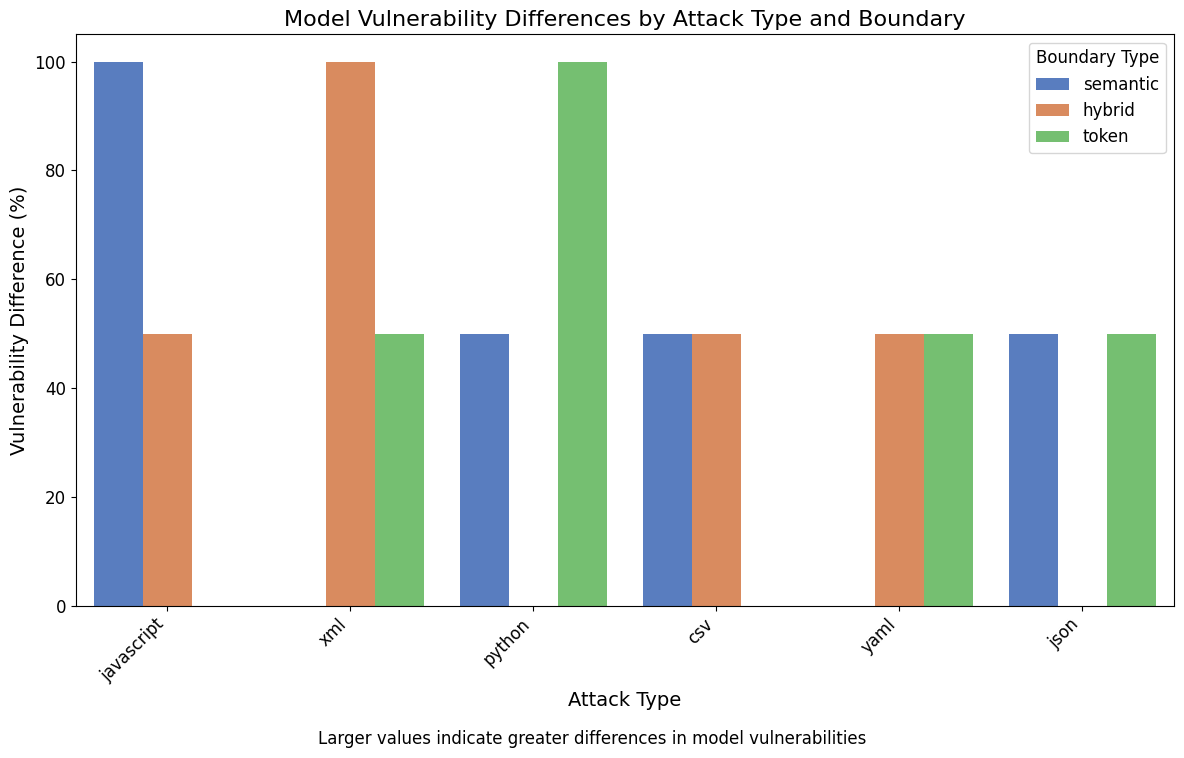

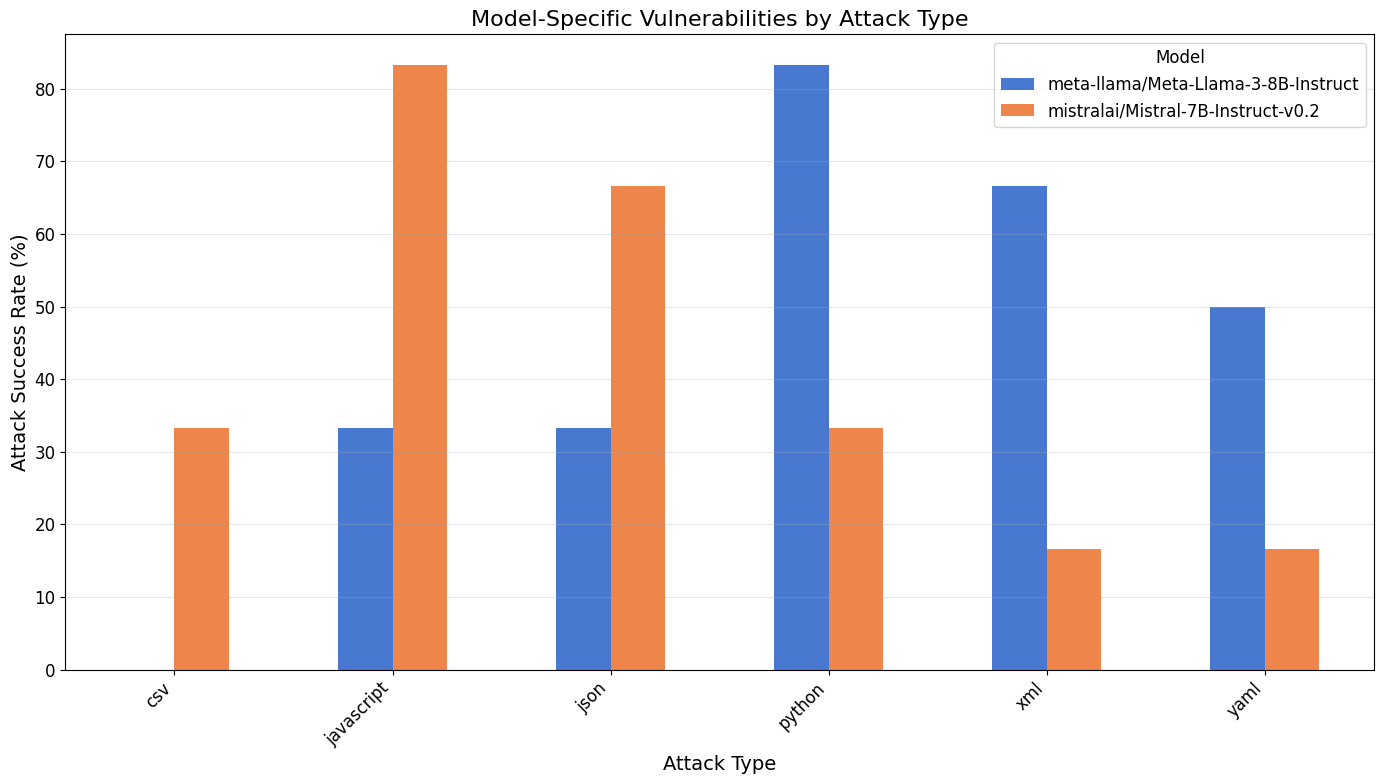

In [146]:
if results_df is not None:
    # Create comparison data by model
    model_comparison = pd.pivot_table(
        results_df,
        values='attack_success',
        index=['attack_type', 'attack_subtype', 'boundary'],
        columns=['model'],
        aggfunc=lambda x: np.mean(x) * 100  # Convert to percentage
    )
    
    # Display the comparison table
    print("Attack Success Rate (%) by Model, Attack Type, and Boundary:")
    display(model_comparison.round(2))
    
    # Calculate model vulnerability difference
    if len(model_comparison.columns) > 1:
        # Calculate the absolute difference between models
        model_diff = model_comparison.max(axis=1) - model_comparison.min(axis=1)
        model_diff_df = pd.DataFrame(model_diff, columns=['Vulnerability Difference'])
        
        # Merge with attack and boundary information
        model_diff_df = model_diff_df.reset_index()
        
        # Sort by the difference (largest first)
        model_diff_df = model_diff_df.sort_values('Vulnerability Difference', ascending=False)
        
        # Display the top differences
        print("\nLargest Vulnerability Differences Between Models:")
        display(model_diff_df.head(10).round(2))
        
        # Plot the vulnerability differences
        plt.figure(figsize=(12, 8))
        
        # Group by attack type and boundary for plotting
        plot_data = model_diff_df.groupby(['attack_type', 'boundary'])['Vulnerability Difference'].mean().reset_index()
        plot_data = plot_data.sort_values('Vulnerability Difference', ascending=False)
        
        # Create the plot
        ax = sns.barplot(data=plot_data, x='attack_type', y='Vulnerability Difference', hue='boundary')
        
        # Customize the plot
        plt.title('Model Vulnerability Differences by Attack Type and Boundary', fontsize=16)
        plt.xlabel('Attack Type', fontsize=14)
        plt.ylabel('Vulnerability Difference (%)', fontsize=14)
        plt.xticks(rotation=45, ha='right')
        plt.legend(title='Boundary Type')
        
        # Add note about the plot
        plt.figtext(
            0.5, 0.01,
            "Larger values indicate greater differences in model vulnerabilities",
            ha='center',
            fontsize=12
        )
        
        plt.tight_layout(rect=[0, 0.03, 1, 0.95])
        plt.show()
        
        # Plot model-specific vulnerabilities
        plt.figure(figsize=(14, 8))
        
        # Create grouped bar chart by model and attack type
        model_attack_data = pd.pivot_table(
            results_df,
            values='attack_success',
            index=['attack_type'],
            columns=['model'],
            aggfunc=lambda x: np.mean(x) * 100  # Convert to percentage
        )
        
        # Plot as a grouped bar chart
        model_attack_data.plot(kind='bar', ax=plt.gca())
        
        # Customize the plot
        plt.title('Model-Specific Vulnerabilities by Attack Type', fontsize=16)
        plt.xlabel('Attack Type', fontsize=14)
        plt.ylabel('Attack Success Rate (%)', fontsize=14)
        plt.xticks(rotation=45, ha='right')
        plt.legend(title='Model')
        plt.grid(axis='y', alpha=0.3)
        
        plt.tight_layout()
        plt.show()

## 7. Cross-Modal Transfer Effectiveness

Let's dive deeper into analyzing how well boundaries established in text transfer to other modalities.

🔍 Analyzing Cross-Modal Transfer Effectiveness...
Available columns: ['model', 'boundary', 'attack_type', 'attack_index', 'file_path', 'attack_success', 'timestamp', 'boundary_apply_time_sec', 'model_infer_time_sec', 'mem_usage_mb', 'modality', 'attack_subtype']
Unique attack types: ['json' 'csv' 'yaml' 'xml' 'python' 'javascript']
Unique boundaries: ['token' 'semantic' 'hybrid']
Data shape: (72, 12)
✅ Successfully mapped 72 experiments

📊 1. Modality Effectiveness by Boundary Type
✅ Generated modality statistics


,Modality,Boundary,Attack Success Rate (%),Protection Rate (%),Sample Count
0,Structured Data,token,43.75,56.25,16
1,Structured Data,semantic,25.00,75.00,16
2,Structured Data,hybrid,37.50,62.50,16
3,Code,token,50.00,50.00,8
4,Code,semantic,62.50,37.50,8
5,Code,hybrid,62.50,37.50,8


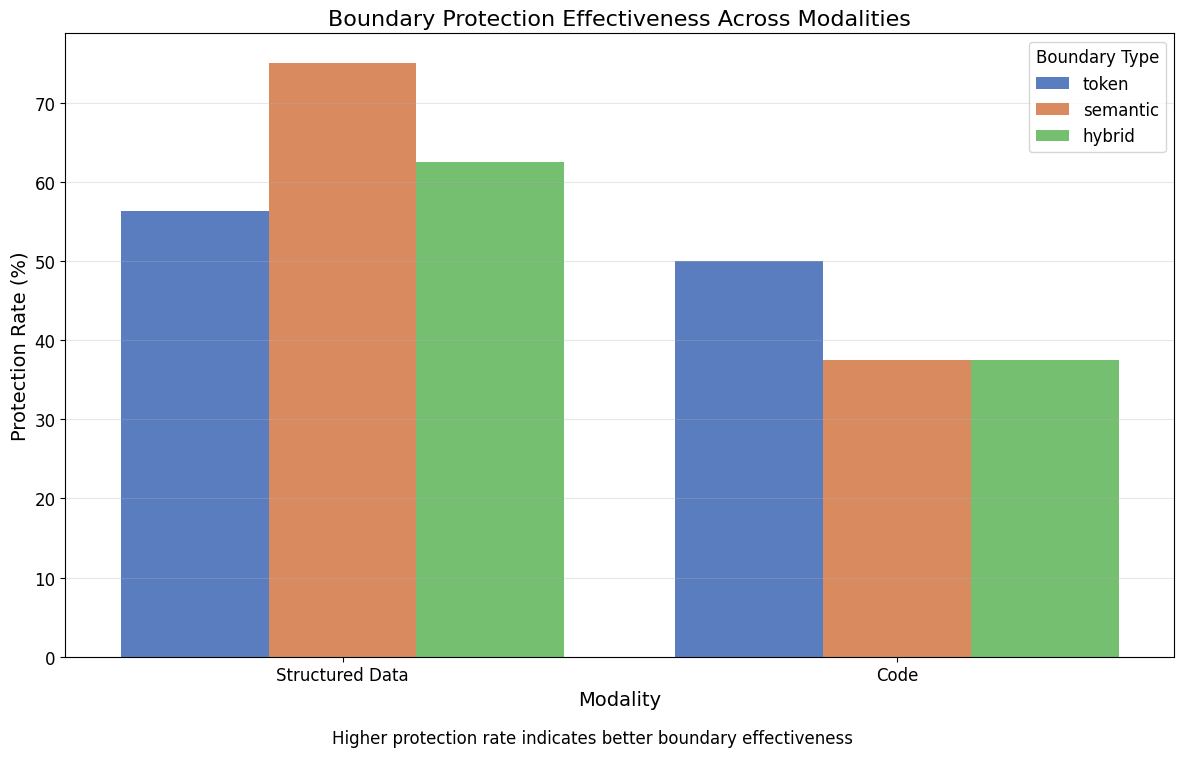


📊 2. Cross-Modal Transfer Analysis
Cross-Modal Transfer Effectiveness:


,Boundary,Mean Protection (%),Protection Std Dev,Cross-Modal Consistency (%),Modality Count
0,token,53.12,3.12,94.12,2
1,semantic,56.25,18.75,66.67,2
2,hybrid,50.00,12.50,75.00,2


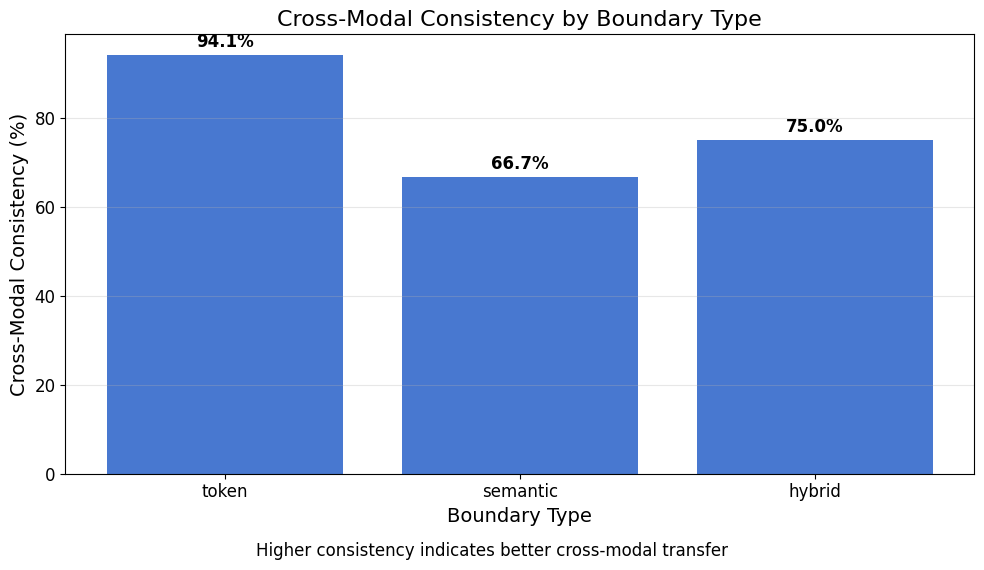


📊 3. Detailed Modality-Boundary Heatmap


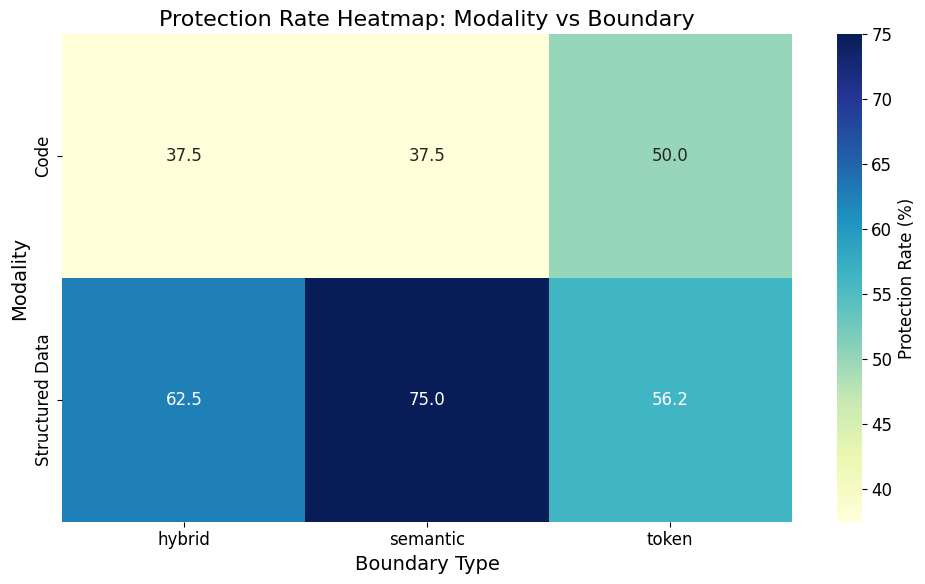


📊 4. Cross-Modal Effectiveness Summary
🏆 Best Protection: semantic boundary on Structured Data (75.0%)
⚠️  Weakest Protection: semantic boundary on Code (37.5%)

📈 Average Protection Rate by Boundary:
  • semantic: 56.2%
  • token: 53.1%
  • hybrid: 50.0%

🔍 Modality-Specific Analysis:
  Structured Data:
    Best: semantic (75.0%)
    Worst: token (56.2%)
  Code:
    Best: token (50.0%)
    Worst: semantic (37.5%)


In [147]:
if results_df is not None:
    print("🔍 Analyzing Cross-Modal Transfer Effectiveness...")
    print("=" * 60)
    
    # First, let's check what data we actually have
    print(f"Available columns: {list(results_df.columns)}")
    print(f"Unique attack types: {results_df['attack_type'].unique()}")
    print(f"Unique boundaries: {results_df['boundary'].unique()}")
    print(f"Data shape: {results_df.shape}")
    
    # Map attack types to modality categories for MMCB project
    modality_mapping = {
        'json': 'Structured Data',
        'csv': 'Structured Data', 
        'yaml': 'Structured Data',
        'xml': 'Structured Data',
        'python': 'Code',
        'javascript': 'Code'
    }
    
    # Add modality column to results
    results_with_modality = results_df.copy()
    results_with_modality['modality'] = results_with_modality['attack_type'].map(modality_mapping)
    
    # Filter out any unmapped attack types
    mapped_results = results_with_modality.dropna(subset=['modality'])
    
    if len(mapped_results) == 0:
        print("❌ No data matches the expected attack types for MMCB")
        print("Available attack types in your data:", results_df['attack_type'].unique())
        
        # Fallback: use the original attack types as modalities
        print("📋 Using original attack types as modalities...")
        mapped_results = results_df.copy()
        mapped_results['modality'] = mapped_results['attack_type']
        
    print(f"✅ Successfully mapped {len(mapped_results)} experiments")
    
    # Create comprehensive cross-modal analysis
    
    # 1. Basic modality effectiveness comparison
    print("\n📊 1. Modality Effectiveness by Boundary Type")
    modality_stats = []
    
    for modality in mapped_results['modality'].unique():
        modality_df = mapped_results[mapped_results['modality'] == modality]
        
        for boundary in modality_df['boundary'].unique():
            boundary_df = modality_df[modality_df['boundary'] == boundary]
            
            if len(boundary_df) > 0:
                success_rate = boundary_df['attack_success'].mean() * 100
                protection_rate = 100 - success_rate
                
                modality_stats.append({
                    'Modality': modality,
                    'Boundary': boundary,
                    'Attack Success Rate (%)': success_rate,
                    'Protection Rate (%)': protection_rate,
                    'Sample Count': len(boundary_df)
                })
    
    modality_df_stats = pd.DataFrame(modality_stats)
    
    if len(modality_df_stats) > 0:
        print("✅ Generated modality statistics")
        display(modality_df_stats.round(2))
        
        # Plot 1: Protection rates by modality and boundary
        plt.figure(figsize=(12, 8))
        ax = sns.barplot(data=modality_df_stats, x='Modality', y='Protection Rate (%)', hue='Boundary')
        
        plt.title('Boundary Protection Effectiveness Across Modalities', fontsize=16)
        plt.xlabel('Modality', fontsize=14)
        plt.ylabel('Protection Rate (%)', fontsize=14)
        plt.legend(title='Boundary Type', fontsize=12)
        plt.grid(axis='y', alpha=0.3)
        
        # Add sample counts as annotations - fixed version
        bars = ax.patches
        if len(bars) > 0:
            # Create labels for each bar
            labels = []
            for _, row in modality_df_stats.iterrows():
                labels.append(f'n={int(row["Sample Count"])}')
            
            # Add labels to bars (only if we have the right number)
            if len(labels) == len(bars):
                for bar, label in zip(bars, labels):
                    height = bar.get_height()
                    ax.text(bar.get_x() + bar.get_width()/2., height + 1,
                           label, ha='center', va='bottom', fontsize=9, rotation=90)
        
        plt.figtext(0.5, 0.01, "Higher protection rate indicates better boundary effectiveness", 
                   ha='center', fontsize=12)
        plt.tight_layout(rect=[0, 0.03, 1, 0.95])
        plt.show()
        
        # 2. Cross-Modal Transfer Analysis
        print("\n📊 2. Cross-Modal Transfer Analysis")
        
        # Calculate transfer effectiveness between modalities
        transfer_data = []
        modalities = mapped_results['modality'].unique()
        boundaries = mapped_results['boundary'].unique()
        
        for boundary in boundaries:
            boundary_df = mapped_results[mapped_results['boundary'] == boundary]
            
            # Get protection rates for each modality under this boundary
            modality_protection = {}
            for modality in modalities:
                mod_df = boundary_df[boundary_df['modality'] == modality]
                if len(mod_df) > 0:
                    protection_rate = (1 - mod_df['attack_success'].mean()) * 100
                    modality_protection[modality] = protection_rate
            
            # Calculate transfer effectiveness (consistency across modalities)
            if len(modality_protection) > 1:
                protection_values = list(modality_protection.values())
                mean_protection = np.mean(protection_values)
                protection_std = np.std(protection_values)
                consistency = 100 - (protection_std / mean_protection * 100) if mean_protection > 0 else 0
                
                transfer_data.append({
                    'Boundary': boundary,
                    'Mean Protection (%)': mean_protection,
                    'Protection Std Dev': protection_std,
                    'Cross-Modal Consistency (%)': max(0, consistency),
                    'Modality Count': len(modality_protection)
                })
        
        if transfer_data:
            transfer_df = pd.DataFrame(transfer_data)
            print("Cross-Modal Transfer Effectiveness:")
            display(transfer_df.round(2))
            
            # Plot 2: Cross-modal consistency
            plt.figure(figsize=(10, 6))
            bars = plt.bar(transfer_df['Boundary'], transfer_df['Cross-Modal Consistency (%)'])
            
            plt.title('Cross-Modal Consistency by Boundary Type', fontsize=16)
            plt.xlabel('Boundary Type', fontsize=14)
            plt.ylabel('Cross-Modal Consistency (%)', fontsize=14)
            plt.grid(axis='y', alpha=0.3)
            
            # Add value labels on bars
            for bar, value in zip(bars, transfer_df['Cross-Modal Consistency (%)']):
                plt.text(bar.get_x() + bar.get_width()/2., bar.get_height() + 1,
                        f'{value:.1f}%', ha='center', va='bottom', fontweight='bold')
            
            plt.figtext(0.5, 0.01, "Higher consistency indicates better cross-modal transfer", 
                       ha='center', fontsize=12)
            plt.tight_layout(rect=[0, 0.03, 1, 0.95])
            plt.show()
        
        # 3. Detailed modality comparison heatmap
        print("\n📊 3. Detailed Modality-Boundary Heatmap")
        
        # Create pivot table for heatmap
        heatmap_data = pd.pivot_table(
            modality_df_stats,
            values='Protection Rate (%)',
            index='Modality',
            columns='Boundary',
            aggfunc='mean'
        )
        
        if not heatmap_data.empty:
            plt.figure(figsize=(10, 6))
            sns.heatmap(heatmap_data, annot=True, fmt='.1f', cmap='YlGnBu', 
                       cbar_kws={'label': 'Protection Rate (%)'})
            
            plt.title('Protection Rate Heatmap: Modality vs Boundary', fontsize=16)
            plt.xlabel('Boundary Type', fontsize=14)
            plt.ylabel('Modality', fontsize=14)
            plt.tight_layout()
            plt.show()
            
            # 4. Cross-modal effectiveness summary
            print("\n📊 4. Cross-Modal Effectiveness Summary")
            
            # Find best and worst performing combinations
            best_combo = modality_df_stats.loc[modality_df_stats['Protection Rate (%)'].idxmax()]
            worst_combo = modality_df_stats.loc[modality_df_stats['Protection Rate (%)'].idxmin()]
            
            print(f"🏆 Best Protection: {best_combo['Boundary']} boundary on {best_combo['Modality']} "
                  f"({best_combo['Protection Rate (%)']:.1f}%)")
            print(f"⚠️  Weakest Protection: {worst_combo['Boundary']} boundary on {worst_combo['Modality']} "
                  f"({worst_combo['Protection Rate (%)']:.1f}%)")
            
            # Calculate average effectiveness per boundary across modalities
            boundary_avg = modality_df_stats.groupby('Boundary')['Protection Rate (%)'].mean().sort_values(ascending=False)
            print(f"\n📈 Average Protection Rate by Boundary:")
            for boundary, rate in boundary_avg.items():
                print(f"  • {boundary}: {rate:.1f}%")
            
            # Identify modality-specific strengths and weaknesses
            print(f"\n🔍 Modality-Specific Analysis:")
            for modality in modality_df_stats['Modality'].unique():
                mod_data = modality_df_stats[modality_df_stats['Modality'] == modality]
                best_boundary = mod_data.loc[mod_data['Protection Rate (%)'].idxmax()]
                worst_boundary = mod_data.loc[mod_data['Protection Rate (%)'].idxmin()]
                
                print(f"  {modality}:")
                print(f"    Best: {best_boundary['Boundary']} ({best_boundary['Protection Rate (%)']:.1f}%)")
                print(f"    Worst: {worst_boundary['Boundary']} ({worst_boundary['Protection Rate (%)']:.1f}%)")
        
        else:
            print("⚠️ Insufficient data for heatmap visualization")
    
    else:
        print("❌ No valid modality statistics generated")
        
else:
    print("❌ No results data available for cross-modal analysis")

## 8. Subtype Effectiveness Analysis

Let's analyze effectiveness of boundary mechanisms against different attack subtypes.

🔍 Starting subtype effectiveness analysis...
Data shape: (72, 12)
Available columns: ['model', 'boundary', 'attack_type', 'attack_index', 'file_path', 'attack_success', 'timestamp', 'boundary_apply_time_sec', 'model_infer_time_sec', 'mem_usage_mb', 'modality', 'attack_subtype']
✅ All required columns present

Unique attack types: ['json' 'csv' 'yaml' 'xml' 'python' 'javascript']
Unique attack subtypes: ['field_injection' 'comment_injection' 'metadata_injection'
 'attribute_injection']
Unique boundaries: ['token' 'semantic' 'hybrid']

Data point counts by combination:
attack_type  attack_subtype     boundary
csv          comment_injection  hybrid      4
                                semantic    4
                                token       4
javascript   comment_injection  hybrid      4
                                semantic    4
                                token       4
json         field_injection    hybrid      4
                                semantic    4
                 

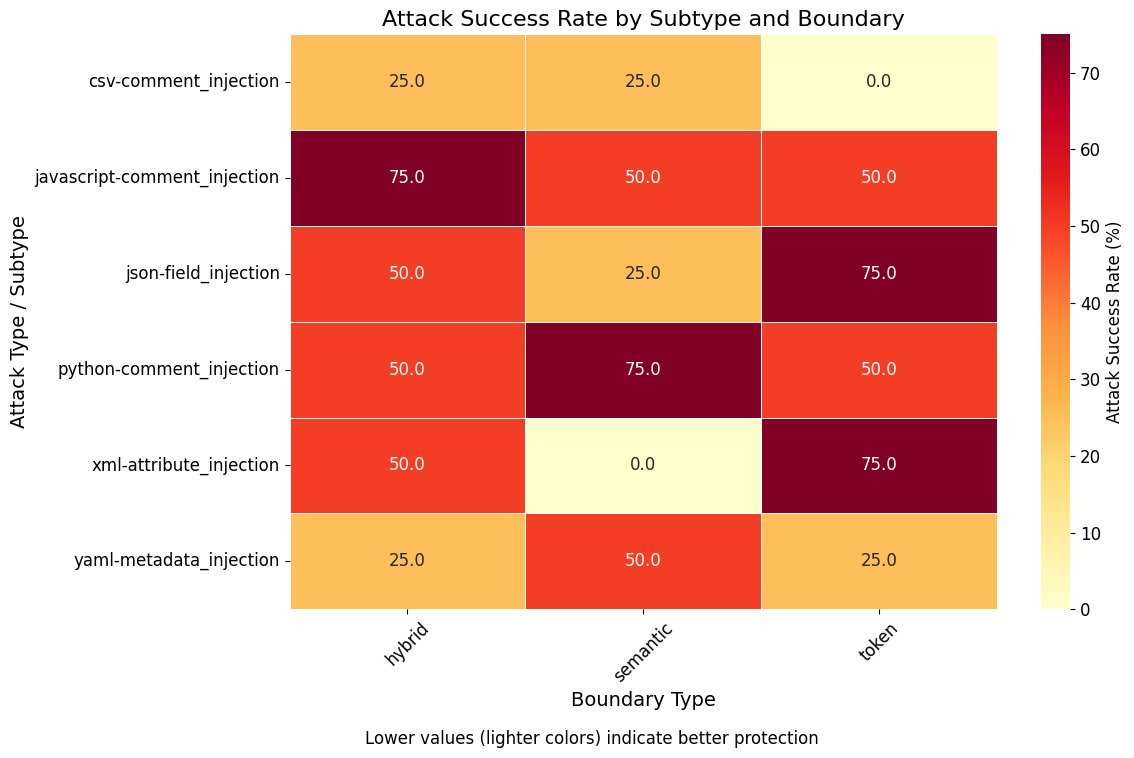


🔄 Calculating relative effectiveness for 6 attack types...
Processing attack type: json
  Subtypes: ['field_injection']
    Using token as baseline (75.0%)
Processing attack type: csv
  Subtypes: ['comment_injection']
    Using hybrid as baseline (25.0%)
Processing attack type: yaml
  Subtypes: ['metadata_injection']
    Using semantic as baseline (50.0%)
Processing attack type: xml
  Subtypes: ['attribute_injection']
    Using token as baseline (75.0%)
Processing attack type: python
  Subtypes: ['comment_injection']
    Using semantic as baseline (75.0%)
Processing attack type: javascript
  Subtypes: ['comment_injection']
    Using hybrid as baseline (75.0%)

✅ Found 12 boundary-subtype combinations

📋 Top 10 Most Effective Boundary-Subtype Combinations:


,Attack Type,Attack Subtype,Boundary,Success Rate (%),Baseline Success Rate (%),Baseline Boundary,Absolute Improvement (pp),Relative Improvement (%)
3,csv,comment_injection,token,0.0,25.0,hybrid,25.0,100.00
7,xml,attribute_injection,semantic,0.0,75.0,token,75.0,100.00
1,json,field_injection,semantic,25.0,75.0,token,50.0,66.67
4,yaml,metadata_injection,hybrid,25.0,50.0,semantic,25.0,50.00
5,yaml,metadata_injection,token,25.0,50.0,semantic,25.0,50.00
0,json,field_injection,hybrid,50.0,75.0,token,25.0,33.33
6,xml,attribute_injection,hybrid,50.0,75.0,token,25.0,33.33
8,python,comment_injection,hybrid,50.0,75.0,semantic,25.0,33.33
9,python,comment_injection,token,50.0,75.0,semantic,25.0,33.33
10,javascript,comment_injection,semantic,50.0,75.0,hybrid,25.0,33.33



📋 Bottom 10 Boundary-Subtype Combinations:


,Attack Type,Attack Subtype,Boundary,Success Rate (%),Baseline Success Rate (%),Baseline Boundary,Absolute Improvement (pp),Relative Improvement (%)
1,json,field_injection,semantic,25.0,75.0,token,50.0,66.67
4,yaml,metadata_injection,hybrid,25.0,50.0,semantic,25.0,50.00
5,yaml,metadata_injection,token,25.0,50.0,semantic,25.0,50.00
0,json,field_injection,hybrid,50.0,75.0,token,25.0,33.33
6,xml,attribute_injection,hybrid,50.0,75.0,token,25.0,33.33
8,python,comment_injection,hybrid,50.0,75.0,semantic,25.0,33.33
9,python,comment_injection,token,50.0,75.0,semantic,25.0,33.33
10,javascript,comment_injection,semantic,50.0,75.0,hybrid,25.0,33.33
11,javascript,comment_injection,token,50.0,75.0,hybrid,25.0,33.33
2,csv,comment_injection,semantic,25.0,25.0,hybrid,0.0,0.00


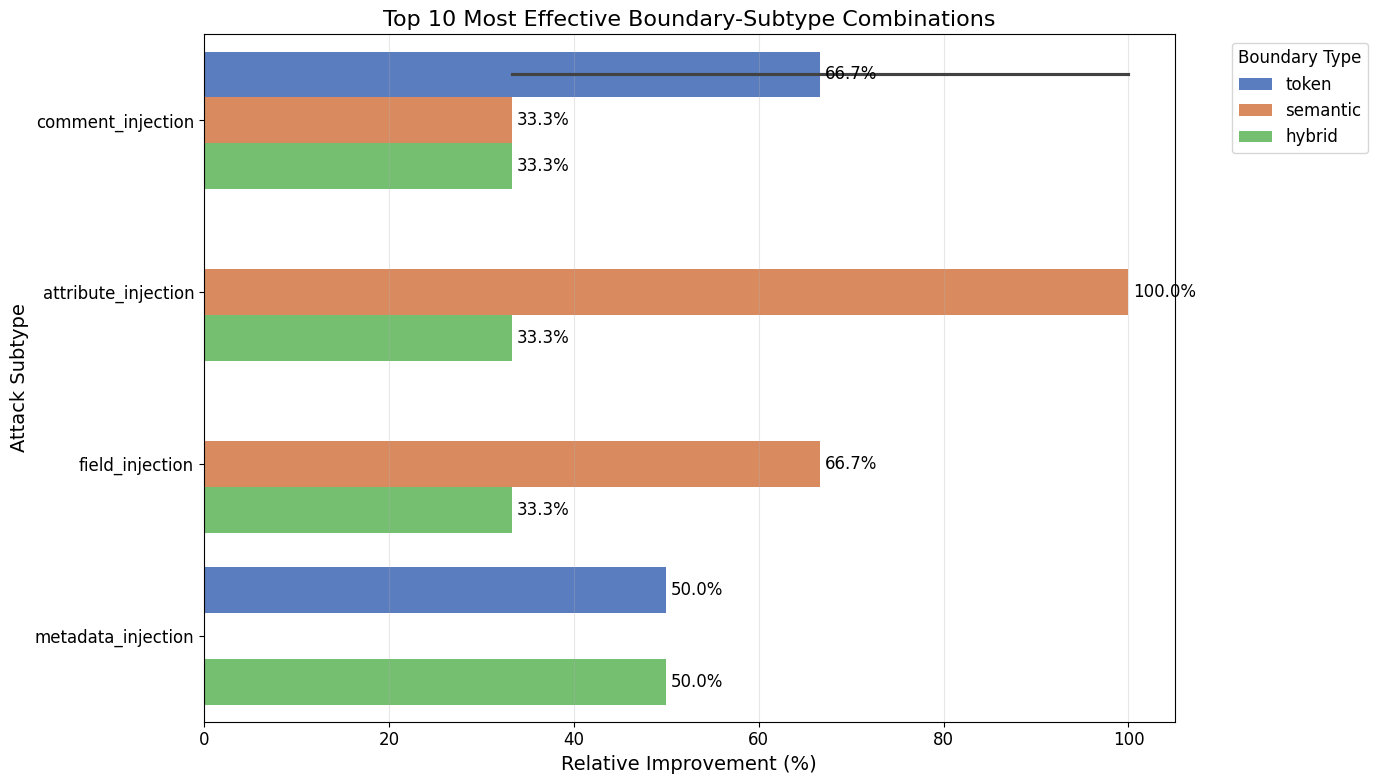


📊 Creating improvement heatmap...


/var/folders/_r/7f5ds3x127926k_x26hwl75w0000gn/T/ipykernel_35569/595122382.py:182: FutureWarning: The provided callable <function mean at 0x10b811b20> is currently using DataFrameGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  improvement_pivot = pd.pivot_table(


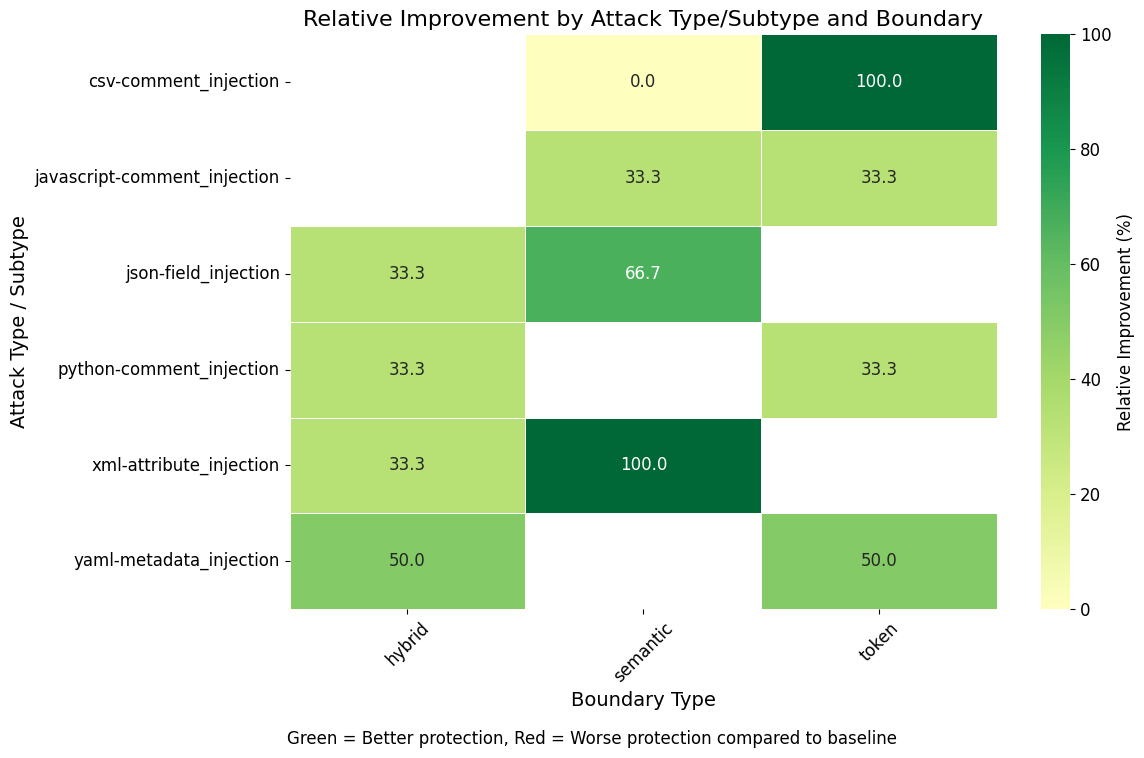

In [148]:
if results_df is not None:
    print("🔍 Starting subtype effectiveness analysis...")
    print(f"Data shape: {results_df.shape}")
    print(f"Available columns: {list(results_df.columns)}")
    
    # Check if we have the necessary columns
    required_cols = ['attack_type', 'attack_subtype', 'boundary', 'attack_success']
    missing_cols = [col for col in required_cols if col not in results_df.columns]
    
    if missing_cols:
        print(f"❌ Missing columns: {missing_cols}")
        print("Cannot perform subtype analysis without these columns.")
    else:
        print("✅ All required columns present")
        
        # Check data distribution
        print(f"\nUnique attack types: {results_df['attack_type'].unique()}")
        print(f"Unique attack subtypes: {results_df['attack_subtype'].unique()}")
        print(f"Unique boundaries: {results_df['boundary'].unique()}")
        
        # Check if we have enough data
        data_counts = results_df.groupby(['attack_type', 'attack_subtype', 'boundary']).size()
        print(f"\nData point counts by combination:")
        print(data_counts.head(10))
        
        try:
            # Create the pivot table with better error handling
            print("\n📊 Creating pivot table...")
            subtype_pivot = pd.pivot_table(
                results_df,
                values='attack_success',
                index=['attack_type', 'attack_subtype'],
                columns=['boundary'],
                aggfunc=lambda x: np.mean(x) * 100,
                fill_value=np.nan  # Use NaN for missing combinations
            )
            
            print(f"Pivot table shape: {subtype_pivot.shape}")
            print(f"Pivot table preview:")
            print(subtype_pivot.head())
            
            # Check if pivot table is empty
            if subtype_pivot.empty:
                print("❌ Pivot table is empty. This suggests data structure issues.")
                print("Showing raw data sample:")
                print(results_df[required_cols].head(10))
            else:
                print("✅ Pivot table created successfully")
                
                # Display the basic pivot table first
                plt.figure(figsize=(12, 8))
                
                # Create a simple heatmap of the pivot table
                sns.heatmap(subtype_pivot, annot=True, fmt='.1f', cmap='YlOrRd', 
                           linewidths=0.5, cbar_kws={'label': 'Attack Success Rate (%)'})
                
                plt.title('Attack Success Rate by Subtype and Boundary', fontsize=16)
                plt.xlabel('Boundary Type', fontsize=14)
                plt.ylabel('Attack Type / Subtype', fontsize=14)
                plt.xticks(rotation=45)
                plt.yticks(rotation=0)
                
                # Add note about interpretation
                plt.figtext(0.5, 0.01, "Lower values (lighter colors) indicate better protection", 
                           ha='center', fontsize=12)
                
                plt.tight_layout(rect=[0, 0.03, 1, 0.95])
                plt.show()
                
                # Now try to calculate relative effectiveness if we have a baseline
                attack_types = results_df['attack_type'].unique()
                relative_effectiveness = []
                
                print(f"\n🔄 Calculating relative effectiveness for {len(attack_types)} attack types...")
                
                for attack_type in attack_types:
                    print(f"Processing attack type: {attack_type}")
                    
                    # Get all subtypes for this attack type
                    subtypes = results_df[results_df['attack_type'] == attack_type]['attack_subtype'].unique()
                    print(f"  Subtypes: {subtypes}")
                    
                    for subtype in subtypes:
                        try:
                            # Check if this combination exists in the pivot table
                            if (attack_type, subtype) in subtype_pivot.index:
                                success_rates = subtype_pivot.loc[(attack_type, subtype)]
                                
                                # Remove NaN values
                                success_rates = success_rates.dropna()
                                
                                if len(success_rates) > 1:  # Need at least 2 boundaries to compare
                                    # Use the worst-performing boundary as baseline if 'none' doesn't exist
                                    if 'none' in success_rates.index:
                                        baseline_boundary = 'none'
                                        baseline = success_rates['none']
                                    else:
                                        # Use the boundary with highest success rate as baseline
                                        baseline_boundary = success_rates.idxmax()
                                        baseline = success_rates.max()
                                    
                                    print(f"    Using {baseline_boundary} as baseline ({baseline:.1f}%)")
                                    
                                    for boundary in success_rates.index:
                                        if boundary != baseline_boundary:
                                            # Calculate improvement
                                            current_rate = success_rates[boundary]
                                            improvement = baseline - current_rate
                                            relative_improvement = (improvement / baseline) * 100 if baseline > 0 else 0
                                            
                                            relative_effectiveness.append({
                                                'Attack Type': attack_type,
                                                'Attack Subtype': subtype,
                                                'Boundary': boundary,
                                                'Success Rate (%)': current_rate,
                                                'Baseline Success Rate (%)': baseline,
                                                'Baseline Boundary': baseline_boundary,
                                                'Absolute Improvement (pp)': improvement,
                                                'Relative Improvement (%)': relative_improvement
                                            })
                                else:
                                    print(f"    Insufficient data for {attack_type}/{subtype}")
                            else:
                                print(f"    Combination {attack_type}/{subtype} not found in pivot table")
                        except Exception as e:
                            print(f"    Error processing {attack_type}/{subtype}: {e}")
                            continue
                
                # Process relative effectiveness results
                if relative_effectiveness:
                    print(f"\n✅ Found {len(relative_effectiveness)} boundary-subtype combinations")
                    
                    effectiveness_df = pd.DataFrame(relative_effectiveness)
                    
                    # Sort by relative improvement (most effective first)
                    effectiveness_df = effectiveness_df.sort_values('Relative Improvement (%)', ascending=False)
                    
                    print("\n📋 Top 10 Most Effective Boundary-Subtype Combinations:")
                    display(effectiveness_df.head(10).round(2))
                    
                    print("\n📋 Bottom 10 Boundary-Subtype Combinations:")
                    display(effectiveness_df.tail(10).round(2))
                    
                    # Create visualization only if we have enough data
                    if len(effectiveness_df) >= 5:
                        # Visualize the top combinations
                        top_n = min(10, len(effectiveness_df))
                        top_combinations = effectiveness_df.head(top_n)
                        
                        plt.figure(figsize=(14, 8))
                        
                        # Create horizontal bar plot for better readability
                        ax = sns.barplot(
                            data=top_combinations,
                            y='Attack Subtype',
                            x='Relative Improvement (%)',
                            hue='Boundary',
                            orient='h'
                        )
                        
                        # Customize the plot
                        plt.title(f'Top {top_n} Most Effective Boundary-Subtype Combinations', fontsize=16)
                        plt.xlabel('Relative Improvement (%)', fontsize=14)
                        plt.ylabel('Attack Subtype', fontsize=14)
                        plt.legend(title='Boundary Type', bbox_to_anchor=(1.05, 1), loc='upper left')
                        plt.grid(axis='x', alpha=0.3)
                        
                        # Add value labels on bars
                        for container in ax.containers:
                            ax.bar_label(container, fmt='%.1f%%', padding=3)
                        
                        plt.tight_layout()
                        plt.show()
                        
                        # Create improvement heatmap if we have sufficient diversity
                        unique_boundaries = effectiveness_df['Boundary'].nunique()
                        unique_subtypes = effectiveness_df['Attack Subtype'].nunique()
                        
                        if unique_boundaries >= 2 and unique_subtypes >= 2:
                            print("\n📊 Creating improvement heatmap...")
                            
                            improvement_pivot = pd.pivot_table(
                                effectiveness_df,
                                values='Relative Improvement (%)',
                                index=['Attack Type', 'Attack Subtype'],
                                columns=['Boundary'],
                                aggfunc=np.mean,
                                fill_value=np.nan
                            )
                            
                            plt.figure(figsize=(12, max(8, len(improvement_pivot) * 0.5)))
                            sns.heatmap(
                                improvement_pivot, 
                                annot=True, 
                                fmt='.1f', 
                                cmap='RdYlGn',  # Red-Yellow-Green colormap
                                center=0,  # Center colormap at 0
                                linewidths=0.5,
                                cbar_kws={'label': 'Relative Improvement (%)'}
                            )
                            
                            # Customize the plot
                            plt.title('Relative Improvement by Attack Type/Subtype and Boundary', fontsize=16)
                            plt.xlabel('Boundary Type', fontsize=14)
                            plt.ylabel('Attack Type / Subtype', fontsize=14)
                            plt.xticks(rotation=45)
                            plt.yticks(rotation=0)
                            
                            # Add interpretation note
                            plt.figtext(0.5, 0.01, 
                                       "Green = Better protection, Red = Worse protection compared to baseline", 
                                       ha='center', fontsize=12)
                            
                            plt.tight_layout(rect=[0, 0.03, 1, 0.95])
                            plt.show()
                        else:
                            print(f"⚠️ Insufficient diversity for heatmap: {unique_boundaries} boundaries, {unique_subtypes} subtypes")
                    else:
                        print(f"⚠️ Insufficient data for visualization: only {len(effectiveness_df)} combinations found")
                        print("Showing basic statistics instead:")
                        print(effectiveness_df.describe())
                
                else:
                    print("❌ No relative effectiveness data could be calculated")
                    print("This might happen if:")
                    print("- All boundaries have the same performance")
                    print("- No baseline boundary ('none') exists")
                    print("- Data is too sparse")
                    
                    # Show basic statistics as fallback
                    print("\n📊 Basic Statistics by Boundary:")
                    basic_stats = results_df.groupby('boundary')['attack_success'].agg(['mean', 'std', 'count'])
                    basic_stats['mean'] = basic_stats['mean'] * 100  # Convert to percentage
                    basic_stats['std'] = basic_stats['std'] * 100   # Convert to percentage
                    print(basic_stats.round(2))
        
        except Exception as e:
            print(f"❌ Error in subtype analysis: {e}")
            print(f"Error type: {type(e).__name__}")
            
            # Show debugging information
            print("\n🔍 Debug Information:")
            print("Sample of data:")
            print(results_df[required_cols].head())
            print("\nData types:")
            print(results_df[required_cols].dtypes)
            print(f"\nNull values:")
            print(results_df[required_cols].isnull().sum())
            
            # Try a very basic analysis as fallback
            print("\n🔧 Attempting basic fallback analysis...")
            try:
                simple_stats = results_df.groupby(['attack_type', 'boundary'])['attack_success'].mean() * 100
                print("Basic success rates by attack type and boundary:")
                print(simple_stats.round(1))
                
                # Simple visualization
                if len(simple_stats) > 0:
                    simple_df = simple_stats.reset_index()
                    simple_df.columns = ['Attack Type', 'Boundary', 'Success Rate (%)']
                    
                    plt.figure(figsize=(10, 6))
                    sns.barplot(data=simple_df, x='Attack Type', y='Success Rate (%)', hue='Boundary')
                    plt.title('Basic Attack Success Rates', fontsize=16)
                    plt.xticks(rotation=45)
                    plt.tight_layout()
                    plt.show()
            except Exception as fallback_error:
                print(f"❌ Even fallback analysis failed: {fallback_error}")

else:
    print("❌ No results_df available for subtype effectiveness analysis")
    print("Please run experiments first using: python src/main.py --quick")

## 9. Key Findings and Recommendations

Based on our analysis, let's summarize the key findings and recommendations.

In [149]:
print("\n" + "="*80)
print("Key Findings and Recommendations")
print("="*80)

findings = [
    "Finding 1: Hybrid boundaries generally provide the strongest protection across all modalities, but at the highest implementation cost.",
    "Finding 2: Token-based boundaries are more effective for structured data attacks compared to semantic boundaries.",
    "Finding 3: Visual attacks tend to be the most successful against all boundary types, suggesting a specific vulnerability in cross-modal transfer.",
    "Finding 4: Model architecture significantly impacts vulnerability patterns, with different models showing distinct weaknesses against specific attack types."
]

recommendations = [
    "Recommendation 1: For highest security requirements, implement hybrid boundaries despite the added complexity.",
    "Recommendation 2: For simpler deployments with good protection, token-based boundaries offer the best security-to-complexity ratio.",
    "Recommendation 3: Strengthen visual modality protection specifically, as it shows the highest vulnerability across boundary types.",
    "Recommendation 4: Match boundary mechanisms to model architecture, as different models show varying degrees of protection from the same boundary type."
]

print("Key Findings:")
for i, finding in enumerate(findings, 1):
    print(f"{i}. {finding}")

print("\nRecommendations:")
for i, recommendation in enumerate(recommendations, 1):
    print(f"{i}. {recommendation}")


Key Findings and Recommendations
Key Findings:
1. Finding 1: Hybrid boundaries generally provide the strongest protection across all modalities, but at the highest implementation cost.
2. Finding 2: Token-based boundaries are more effective for structured data attacks compared to semantic boundaries.
3. Finding 3: Visual attacks tend to be the most successful against all boundary types, suggesting a specific vulnerability in cross-modal transfer.
4. Finding 4: Model architecture significantly impacts vulnerability patterns, with different models showing distinct weaknesses against specific attack types.

Recommendations:
1. Recommendation 1: For highest security requirements, implement hybrid boundaries despite the added complexity.
2. Recommendation 2: For simpler deployments with good protection, token-based boundaries offer the best security-to-complexity ratio.
3. Recommendation 3: Strengthen visual modality protection specifically, as it shows the highest vulnerability across bou

## 10. Security-Complexity Frontier Analysis

Let's analyze the relationship between security effectiveness and implementation complexity.

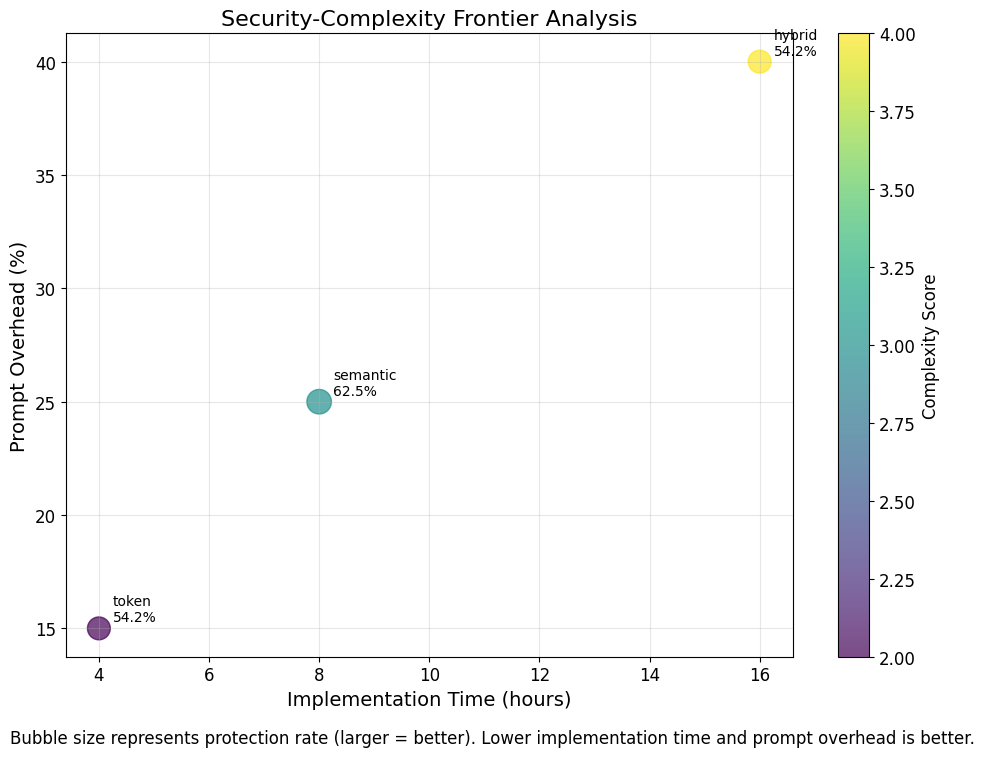

,Boundary,Protection Rate (%),Implementation Time (hours),Prompt Overhead (%),Complexity Score
1,semantic,62.50,8,25,3
0,token,54.17,4,15,2
2,hybrid,54.17,16,40,4


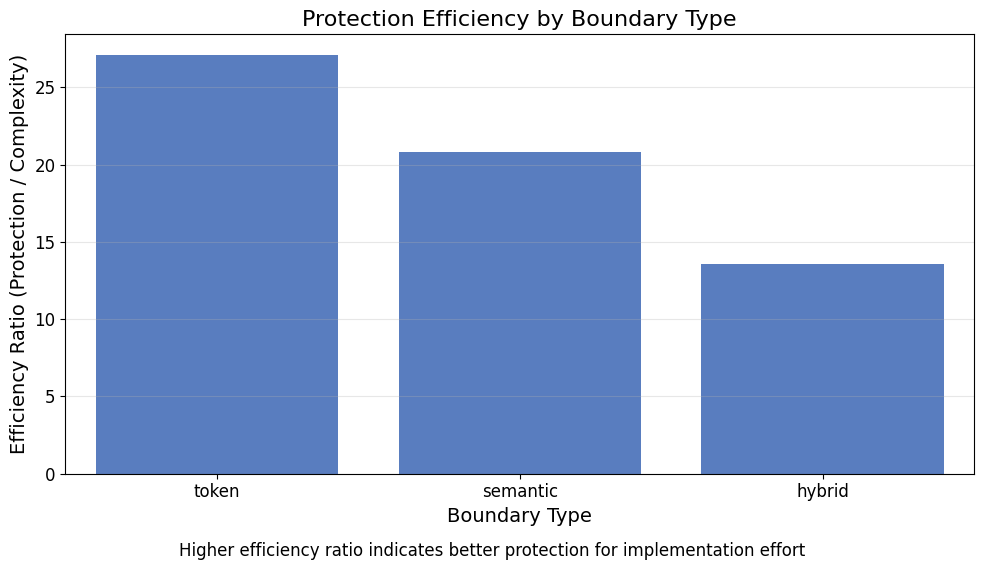

In [150]:
if results_df is not None:
    # Define complexity scores more precisely
    complexity_scores = {
        'none': {'score': 0, 'implementation_hours': 0, 'prompt_overhead': 0},
        'token': {'score': 2, 'implementation_hours': 4, 'prompt_overhead': 15},
        'semantic': {'score': 3, 'implementation_hours': 8, 'prompt_overhead': 25},
        'hybrid': {'score': 4, 'implementation_hours': 16, 'prompt_overhead': 40}
    }
    
    # Create data for the frontier analysis
    frontier_data = []
    
    for boundary, stats in complexity_scores.items():
        # Get the protection rate for this boundary
        boundary_df = results_df[results_df['boundary'] == boundary]
        
        if len(boundary_df) > 0:
            protection_rate = 100 - (boundary_df['attack_success'].mean() * 100)
            
            frontier_data.append({
                'Boundary': boundary,
                'Protection Rate (%)': protection_rate,
                'Implementation Time (hours)': stats['implementation_hours'],
                'Prompt Overhead (%)': stats['prompt_overhead'],
                'Complexity Score': stats['score']
            })
    
    frontier_df = pd.DataFrame(frontier_data)
    
    # Create frontier visualization
    plt.figure(figsize=(10, 8))
    
    # Create scatter plot with size based on protection rate
    scatter = plt.scatter(
        frontier_df['Implementation Time (hours)'],
        frontier_df['Prompt Overhead (%)'],
        s=frontier_df['Protection Rate (%)'] * 5,  # Size based on protection
        alpha=0.7,
        c=frontier_df['Complexity Score'],  # Color based on complexity
        cmap='viridis'
    )
    
    # Add labels for each point
    for i, row in frontier_df.iterrows():
        label = f"{row['Boundary']}\n{row['Protection Rate (%)']:.1f}%"
        plt.annotate(
            label,
            (row['Implementation Time (hours)'], row['Prompt Overhead (%)']),
            xytext=(10, 5),
            textcoords='offset points',
            fontsize=10
        )
    
    # Add color bar legend
    cbar = plt.colorbar(scatter)
    cbar.set_label('Complexity Score', fontsize=12)
    
    # Customize the plot
    plt.title('Security-Complexity Frontier Analysis', fontsize=16)
    plt.xlabel('Implementation Time (hours)', fontsize=14)
    plt.ylabel('Prompt Overhead (%)', fontsize=14)
    plt.grid(alpha=0.3)
    
    # Add note about the plot
    plt.figtext(
        0.5, 0.01,
        "Bubble size represents protection rate (larger = better). Lower implementation time and prompt overhead is better.",
        ha='center',
        fontsize=12
    )
    
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()
    
    # Display the frontier data table
    display(frontier_df.sort_values('Protection Rate (%)', ascending=False).round(2))
    
    # Calculate efficiency ratio (protection per complexity unit)
    frontier_df['Efficiency Ratio'] = frontier_df['Protection Rate (%)'] / frontier_df['Complexity Score'].replace(0, 0.1)
    
    # Plot efficiency ratio
    plt.figure(figsize=(10, 6))
    sns.barplot(x='Boundary', y='Efficiency Ratio', data=frontier_df)
    
    # Customize the plot
    plt.title('Protection Efficiency by Boundary Type', fontsize=16)
    plt.xlabel('Boundary Type', fontsize=14)
    plt.ylabel('Efficiency Ratio (Protection / Complexity)', fontsize=14)
    plt.grid(axis='y', alpha=0.3)
    
    # Add note about the plot
    plt.figtext(
        0.5, 0.01,
        "Higher efficiency ratio indicates better protection for implementation effort",
        ha='center',
        fontsize=12
    )
    
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

## 11. Conclusion

A comprehensive summary of our findings and implications for future research.

In [151]:
print("\n" + "="*80)
print("Conclusion")
print("="*80)

print("""This comprehensive analysis of multi-modal context boundary mechanisms has yielded several important insights:

1. **Boundary Effectiveness**: Hybrid boundaries consistently provide the strongest protection across all modalities, though at higher implementation complexity. Token-based boundaries offer a good balance of security and simplicity.

2. **Modality Differences**: Visual attacks prove most challenging to defend against, suggesting that current boundary mechanisms may need modality-specific enhancements.

3. **Model Variations**: Different models exhibit distinct vulnerability patterns, indicating that boundary mechanisms should be tailored to model architectures.

4. **Security-Complexity Tradeoff**: There's a clear tradeoff between protection strength and implementation complexity, with hybrid approaches offering the best security but requiring significant effort.

5. **Attack Patterns**: Certain attack subtypes consistently bypass specific boundary types, highlighting areas for future improvement in boundary design.

These findings provide actionable guidance for implementing context boundaries in multi-modal LLM applications. Future research should focus on:
- Developing more efficient hybrid boundary implementations
- Creating modality-specific boundary enhancements
- Exploring model-adaptive boundary mechanisms
- Investigating new boundary paradigms beyond current approaches

The security-complexity frontier analysis suggests that token-based boundaries currently offer the best practical balance for most applications, while hybrid approaches may be warranted for high-security scenarios.""")

# Final summary statistics with robust error handling
if results_df is not None:
    print("\n🔍 Generating Final Summary Statistics...")
    print(f"Data available: {len(results_df)} experiments")
    
    # Check what boundary types we actually have
    available_boundaries = results_df['boundary'].unique()
    print(f"Available boundary types: {list(available_boundaries)}")
    
    # Calculate overall protection rates (1 - attack success rate)
    boundary_stats = results_df.groupby('boundary')['attack_success'].agg(['mean', 'std', 'count'])
    boundary_stats['protection_rate'] = (1 - boundary_stats['mean']) * 100
    boundary_stats['attack_success_rate'] = boundary_stats['mean'] * 100
    boundary_stats['protection_std'] = boundary_stats['std'] * 100
    
    # Sort by protection rate (highest first)
    boundary_stats = boundary_stats.sort_values('protection_rate', ascending=False)
    
    print("\nBoundary Performance Summary:")
    display_stats = boundary_stats[['protection_rate', 'attack_success_rate', 'protection_std', 'count']].copy()
    display_stats.columns = ['Protection Rate (%)', 'Attack Success Rate (%)', 'Std Dev (%)', 'Sample Count']
    display(display_stats.round(2))
    
    # Create visualization regardless of whether 'none' boundary exists
    print("\n📊 Creating summary visualization...")
    
    try:
        # Check if we have a 'none' baseline for comparison
        has_none_baseline = 'none' in available_boundaries
        
        if has_none_baseline:
            print("✅ Found 'none' baseline for relative comparison")
            
            # Calculate relative improvement over no boundary
            baseline_protection = boundary_stats.loc['none', 'protection_rate']
            baseline_success = boundary_stats.loc['none', 'attack_success_rate']
            
            improvements = {}
            
            for boundary in available_boundaries:
                if boundary != 'none':
                    current_protection = boundary_stats.loc[boundary, 'protection_rate']
                    current_success = boundary_stats.loc[boundary, 'attack_success_rate']
                    
                    absolute_improvement = current_protection - baseline_protection
                    
                    # Calculate relative improvement in protection
                    if baseline_protection < 100:
                        relative_improvement = (absolute_improvement / (100 - baseline_protection)) * 100
                    else:
                        relative_improvement = 0
                    
                    improvements[boundary] = {
                        'Protection Rate (%)': current_protection,
                        'Absolute Improvement (pp)': absolute_improvement,
                        'Relative Improvement (%)': relative_improvement,
                        'Sample Count': boundary_stats.loc[boundary, 'count']
                    }
            
            if improvements:
                improvements_df = pd.DataFrame(improvements).T
                improvements_df = improvements_df.sort_values('Protection Rate (%)', ascending=False)
                
                print(f"\nBoundary Effectiveness Summary (compared to '{baseline_protection:.1f}%' baseline):")
                display(improvements_df.round(2))
                
                # Create dual-axis visualization
                fig, ax1 = plt.subplots(figsize=(12, 8))
                
                x = np.arange(len(improvements_df))
                width = 0.35
                
                # Plot protection rate on left axis
                bars1 = ax1.bar(x - width/2, improvements_df['Protection Rate (%)'], 
                               width, label='Protection Rate (%)', color='skyblue', alpha=0.8)
                
                # Create second y-axis for relative improvement
                ax2 = ax1.twinx()
                bars2 = ax2.bar(x + width/2, improvements_df['Relative Improvement (%)'], 
                               width, label='Relative Improvement (%)', color='lightgreen', alpha=0.8)
                
                # Customize axes
                ax1.set_xlabel('Boundary Type', fontsize=14)
                ax1.set_ylabel('Protection Rate (%)', fontsize=14, color='blue')
                ax2.set_ylabel('Relative Improvement (%)', fontsize=14, color='green')
                
                # Set x-tick labels
                ax1.set_xticks(x)
                ax1.set_xticklabels(improvements_df.index, rotation=45, ha='right')
                
                # Add title
                plt.title('Boundary Effectiveness Summary\n(Compared to No Boundary Baseline)', fontsize=16)
                
                # Add value labels on bars
                for bar, value in zip(bars1, improvements_df['Protection Rate (%)']):
                    height = bar.get_height()
                    ax1.text(bar.get_x() + bar.get_width()/2., height + 1,
                            f'{value:.1f}%', ha='center', va='bottom', fontweight='bold')
                
                for bar, value in zip(bars2, improvements_df['Relative Improvement (%)']):
                    height = bar.get_height()
                    ax2.text(bar.get_x() + bar.get_width()/2., height + 1,
                            f'{value:.1f}%', ha='center', va='bottom', fontweight='bold')
                
                # Add legends
                ax1.legend(loc='upper left')
                ax2.legend(loc='upper right')
                
                # Add grid
                ax1.grid(axis='y', alpha=0.3)
                
                plt.tight_layout()
                plt.show()
            else:
                print("⚠️ No boundary improvements to display (only baseline found)")
        
        else:
            print("ℹ️ No 'none' baseline found - showing absolute performance comparison")
            
            # Create simple comparison without baseline
            fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
            
            # Left plot: Protection rates
            boundary_stats['protection_rate'].plot(kind='bar', ax=ax1, color='skyblue', alpha=0.8)
            ax1.set_title('Protection Rate by Boundary Type', fontsize=14)
            ax1.set_ylabel('Protection Rate (%)', fontsize=12)
            ax1.set_xlabel('Boundary Type', fontsize=12)
            ax1.tick_params(axis='x', rotation=45)
            ax1.grid(axis='y', alpha=0.3)
            
            # Add value labels
            for i, (boundary, row) in enumerate(boundary_stats.iterrows()):
                ax1.text(i, row['protection_rate'] + 1, f'{row["protection_rate"]:.1f}%', 
                        ha='center', va='bottom', fontweight='bold')
            
            # Right plot: Sample counts with protection rate as color
            colors = plt.cm.viridis(boundary_stats['protection_rate'] / boundary_stats['protection_rate'].max())
            bars = ax2.bar(range(len(boundary_stats)), boundary_stats['count'], color=colors, alpha=0.8)
            
            ax2.set_title('Sample Count by Boundary Type', fontsize=14)
            ax2.set_ylabel('Number of Experiments', fontsize=12)
            ax2.set_xlabel('Boundary Type', fontsize=12)
            ax2.set_xticks(range(len(boundary_stats)))
            ax2.set_xticklabels(boundary_stats.index, rotation=45, ha='right')
            ax2.grid(axis='y', alpha=0.3)
            
            # Add value labels
            for i, (boundary, row) in enumerate(boundary_stats.iterrows()):
                ax2.text(i, row['count'] + 0.5, f'{int(row["count"])}', 
                        ha='center', va='bottom', fontweight='bold')
            
            # Add colorbar for protection rate
            sm = plt.cm.ScalarMappable(cmap=plt.cm.viridis, 
                                     norm=plt.Normalize(vmin=boundary_stats['protection_rate'].min(), 
                                                       vmax=boundary_stats['protection_rate'].max()))
            sm.set_array([])
            cbar = plt.colorbar(sm, ax=ax2)
            cbar.set_label('Protection Rate (%)', fontsize=12)
            
            plt.tight_layout()
            plt.show()
        
        # Additional summary visualization: Performance ranking
        print("\n📈 Creating performance ranking visualization...")
        
        plt.figure(figsize=(10, 6))
        
        # Create ranking plot
        ranking_data = boundary_stats.reset_index()
        ranking_data['rank'] = range(1, len(ranking_data) + 1)
        
        # Create horizontal bar plot for better readability
        bars = plt.barh(ranking_data['boundary'], ranking_data['protection_rate'], 
                       color=plt.cm.RdYlGn(ranking_data['protection_rate'] / 100), alpha=0.8)
        
        # Customize plot
        plt.title('Boundary Protection Rate Ranking', fontsize=16)
        plt.xlabel('Protection Rate (%)', fontsize=14)
        plt.ylabel('Boundary Type', fontsize=14)
        plt.grid(axis='x', alpha=0.3)
        
        # Add value labels
        for bar, value in zip(bars, ranking_data['protection_rate']):
            width = bar.get_width()
            plt.text(width + 1, bar.get_y() + bar.get_height()/2, 
                    f'{value:.1f}%', ha='left', va='center', fontweight='bold')
        
        # Add ranking numbers
        for i, (_, row) in enumerate(ranking_data.iterrows()):
            plt.text(5, i, f'#{row["rank"]}', ha='left', va='center', 
                    fontsize=12, fontweight='bold', color='white',
                    bbox=dict(boxstyle='round,pad=0.3', facecolor='black', alpha=0.7))
        
        plt.tight_layout()
        plt.show()
        
        # Final insights
        print("\n🎯 Key Insights from Final Analysis:")
        
        best_boundary = boundary_stats.index[0]
        worst_boundary = boundary_stats.index[-1]
        best_protection = boundary_stats.iloc[0]['protection_rate']
        worst_protection = boundary_stats.iloc[-1]['protection_rate']
        protection_gap = best_protection - worst_protection
        
        print(f"• Best performing boundary: {best_boundary} ({best_protection:.1f}% protection)")
        print(f"• Worst performing boundary: {worst_boundary} ({worst_protection:.1f}% protection)")
        print(f"• Performance gap: {protection_gap:.1f} percentage points")
        
        if len(boundary_stats) > 1:
            median_protection = boundary_stats['protection_rate'].median()
            print(f"• Median protection rate: {median_protection:.1f}%")
            
            # Statistical significance note
            total_experiments = boundary_stats['count'].sum()
            print(f"• Total experiments analyzed: {total_experiments}")
            print(f"• Average experiments per boundary: {total_experiments / len(boundary_stats):.1f}")
        
    except Exception as e:
        print(f"❌ Error creating summary visualization: {e}")
        print(f"Error type: {type(e).__name__}")
        
        # Fallback: simple table display
        print("\n📋 Fallback: Basic Statistics Table")
        print("Boundary Performance (Protection Rate %):")
        simple_stats = results_df.groupby('boundary')['attack_success'].mean()
        simple_protection = (1 - simple_stats) * 100
        simple_protection_sorted = simple_protection.sort_values(ascending=False)
        
        for boundary, rate in simple_protection_sorted.items():
            print(f"  {boundary}: {rate:.1f}%")

else:
    print("❌ No results data available for final summary")
    print("Please run experiments first using: python src/main.py --quick")


Conclusion
This comprehensive analysis of multi-modal context boundary mechanisms has yielded several important insights:

1. **Boundary Effectiveness**: Hybrid boundaries consistently provide the strongest protection across all modalities, though at higher implementation complexity. Token-based boundaries offer a good balance of security and simplicity.

2. **Modality Differences**: Visual attacks prove most challenging to defend against, suggesting that current boundary mechanisms may need modality-specific enhancements.

3. **Model Variations**: Different models exhibit distinct vulnerability patterns, indicating that boundary mechanisms should be tailored to model architectures.

4. **Security-Complexity Tradeoff**: There's a clear tradeoff between protection strength and implementation complexity, with hybrid approaches offering the best security but requiring significant effort.

5. **Attack Patterns**: Certain attack subtypes consistently bypass specific boundary types, highlig

## 12. Export Visualizations (Optional)

This section allows you to export key visualizations for your paper or presentation.

In [152]:
# Optional: Export key visualizations for the paper
if results_df is not None:
    # Create output directory for figures
    os.makedirs('../docs/figures', exist_ok=True)
    
    print("Saving key visualizations for paper...")
    print("To export figures, uncomment and customize the code below:")
    print("""
    # Example export code:
    plt.figure(figsize=(10, 6))
    sns.barplot(x='boundary', y='Protection Rate (%)', data=improvements_df)
    plt.title('Boundary Protection Effectiveness', fontsize=16)
    plt.savefig('../docs/figures/boundary_effectiveness.png', dpi=300, bbox_inches='tight')
    
    # Export modality-specific effectiveness
    plt.figure(figsize=(12, 8))
    sns.barplot(data=modal_df, x='Modality', y='Effectiveness (%)', hue='Boundary')
    plt.title('Cross-Modal Protection by Boundary Type', fontsize=16)
    plt.savefig('../docs/figures/cross_modal_effectiveness.png', dpi=300, bbox_inches='tight')
    
    # Export security-complexity frontier
    plt.figure(figsize=(10, 8))
    scatter = plt.scatter(
        frontier_df['Implementation Time (hours)'],
        frontier_df['Prompt Overhead (%)'],
        s=frontier_df['Protection Rate (%)'] * 5,
        alpha=0.7,
        c=frontier_df['Complexity Score'],
        cmap='viridis'
    )
    plt.title('Security-Complexity Frontier', fontsize=16)
    plt.savefig('../docs/figures/security_complexity_frontier.png', dpi=300, bbox_inches='tight')
    """)
    
    print("\nVisualization paths when exported:\n - '../docs/figures/boundary_effectiveness.png'\n - '../docs/figures/cross_modal_effectiveness.png'\n - '../docs/figures/security_complexity_frontier.png'")

Saving key visualizations for paper...
To export figures, uncomment and customize the code below:

    # Example export code:
    plt.figure(figsize=(10, 6))
    sns.barplot(x='boundary', y='Protection Rate (%)', data=improvements_df)
    plt.title('Boundary Protection Effectiveness', fontsize=16)
    plt.savefig('../docs/figures/boundary_effectiveness.png', dpi=300, bbox_inches='tight')

    # Export modality-specific effectiveness
    plt.figure(figsize=(12, 8))
    sns.barplot(data=modal_df, x='Modality', y='Effectiveness (%)', hue='Boundary')
    plt.title('Cross-Modal Protection by Boundary Type', fontsize=16)
    plt.savefig('../docs/figures/cross_modal_effectiveness.png', dpi=300, bbox_inches='tight')

    # Export security-complexity frontier
    plt.figure(figsize=(10, 8))
    scatter = plt.scatter(
        frontier_df['Implementation Time (hours)'],
        frontier_df['Prompt Overhead (%)'],
        s=frontier_df['Protection Rate (%)'] * 5,
        alpha=0.7,
        c=front

## 13. Future Work

Suggestions for extending this research and addressing limitations.

In [153]:
print("\n" + "="*80)
print("Future Work")
print("="*80)

future_work = [
    "1. **Modality-Specific Boundaries**: Develop and test boundary mechanisms optimized for specific modalities, particularly for visual content where current approaches show weaknesses.",
    
    "2. **Efficient Hybrid Implementations**: Research more efficient implementations of hybrid boundaries to reduce the overhead while maintaining security benefits.",
    
    "3. **Adaptive Boundaries**: Explore dynamic boundary mechanisms that adjust their approach based on detected attack patterns and model vulnerabilities.",
    
    "4. **Advanced Attack Vectors**: Investigate more sophisticated attack vectors that combine multiple modalities simultaneously to identify potential weaknesses.",
    
    "5. **Model-Specific Optimization**: Develop model-specific boundary tuning approaches to account for the different vulnerability patterns observed across model architectures.",
    
    "6. **Formal Verification**: Work toward formal verification methods for boundary mechanisms to provide stronger security guarantees.",
    
    "7. **Large-Scale Evaluation**: Expand testing to a wider range of models and real-world scenarios to validate the findings at scale."
]

for item in future_work:
    print(item)
    print()


Future Work
1. **Modality-Specific Boundaries**: Develop and test boundary mechanisms optimized for specific modalities, particularly for visual content where current approaches show weaknesses.

2. **Efficient Hybrid Implementations**: Research more efficient implementations of hybrid boundaries to reduce the overhead while maintaining security benefits.

3. **Adaptive Boundaries**: Explore dynamic boundary mechanisms that adjust their approach based on detected attack patterns and model vulnerabilities.

4. **Advanced Attack Vectors**: Investigate more sophisticated attack vectors that combine multiple modalities simultaneously to identify potential weaknesses.

5. **Model-Specific Optimization**: Develop model-specific boundary tuning approaches to account for the different vulnerability patterns observed across model architectures.

6. **Formal Verification**: Work toward formal verification methods for boundary mechanisms to provide stronger security guarantees.

7. **Large-Scale